# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.88'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne--Spectrum--000--Spec.Data 1.txt',
 '02 Ne--Spectrum--001--Spec.Data 1.txt',
 '03 Ne--Spectrum--002--Spec.Data 1.txt',
 '08 Ne--Spectrum--015--Spec.Data 1.txt',
 '11 Ne--Spectrum--020--Spec.Data 1.txt',
 '15 Ne--Spectrum--026--Spec.Data 1.txt',
 '20 Ne--Spectrum--032--Spec.Data 1.txt',
 '22 Ne--Spectrum--043--Spec.Data 1.txt',
 '25 Ne--Spectrum--048--Spec.Data 1.txt',
 '35 Ne--Spectrum--060--Spec.Data 1.txt',
 '39 Ne--Spectrum--073--Spec.Data 1.txt',
 '43 Ne--Spectrum--079--Spec.Data 1.txt',
 '47 Ne--Spectrum--090--Spec.Data 1.txt',
 '51 Ne--Spectrum--096--Spec.Data 1.txt',
 '59 Ne--Spectrum--106--Spec.Data 1.txt',
 '73 Ne--Spectrum--130--Spec.Data 1.txt',
 '77 Ne--Spectrum--137--Spec.Data 1.txt',
 '84 Ne--Spectrum--157--Spec.Data 1.txt',
 '89 Ne--Spectrum--166--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
3           391.536362     2500.0                543.36513
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--000--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583   4924.666504  1447.138537   46808.66797  4210.799835   

     Peak2_prom  
0  46094.801301

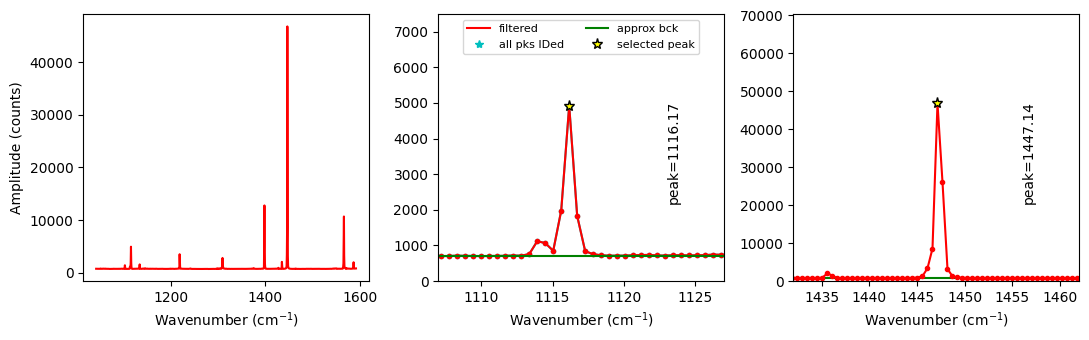

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--000--Spec.Data 1.txt         0.000038    0.000038   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0    1447.280538   47119.211386   0.378277      None   0.002246   

   Peak2_Prop_Lor  pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe  Ne_Corr  \
0        0.378884    1116.150616  ...        0.286513  331.129922  0.99803   

   Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0     0.997986     0.998074    111.955278       9.29159        121.246868   

   error_pk1_amplitude  error_pk2_amplitude  
0           170.949728           358.733512  

[1 rows x 24 columns]

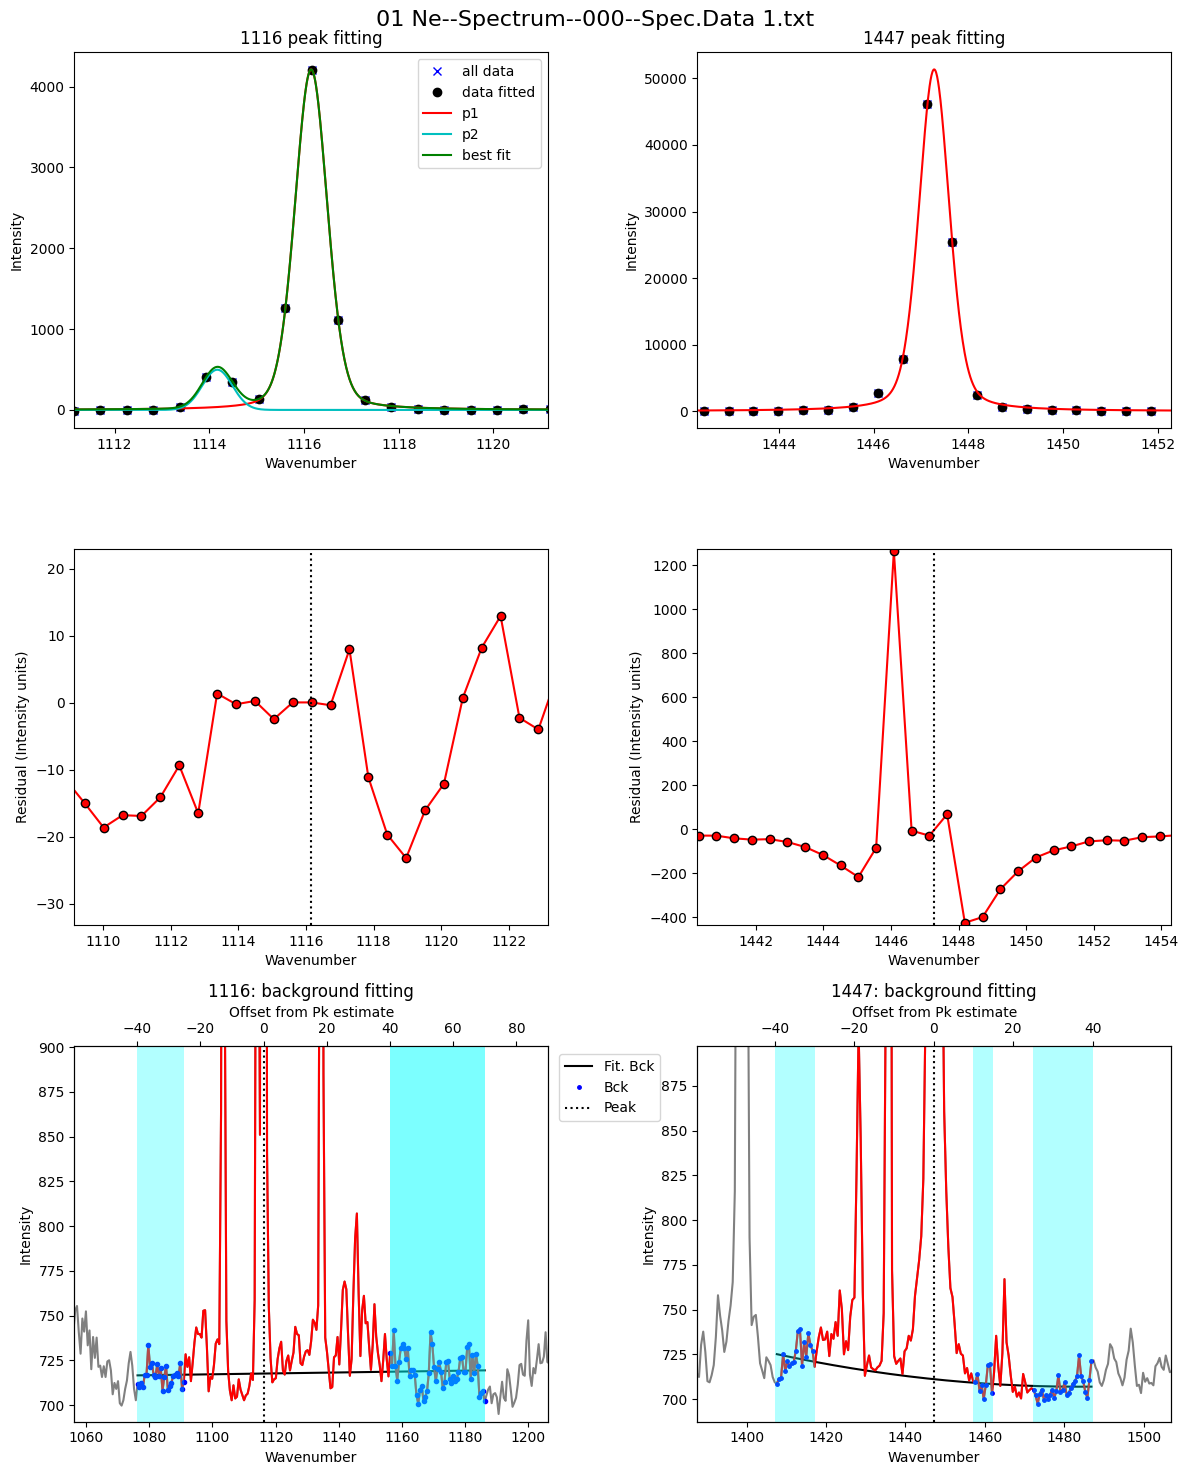

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/19 [00:00<?, ?it/s]

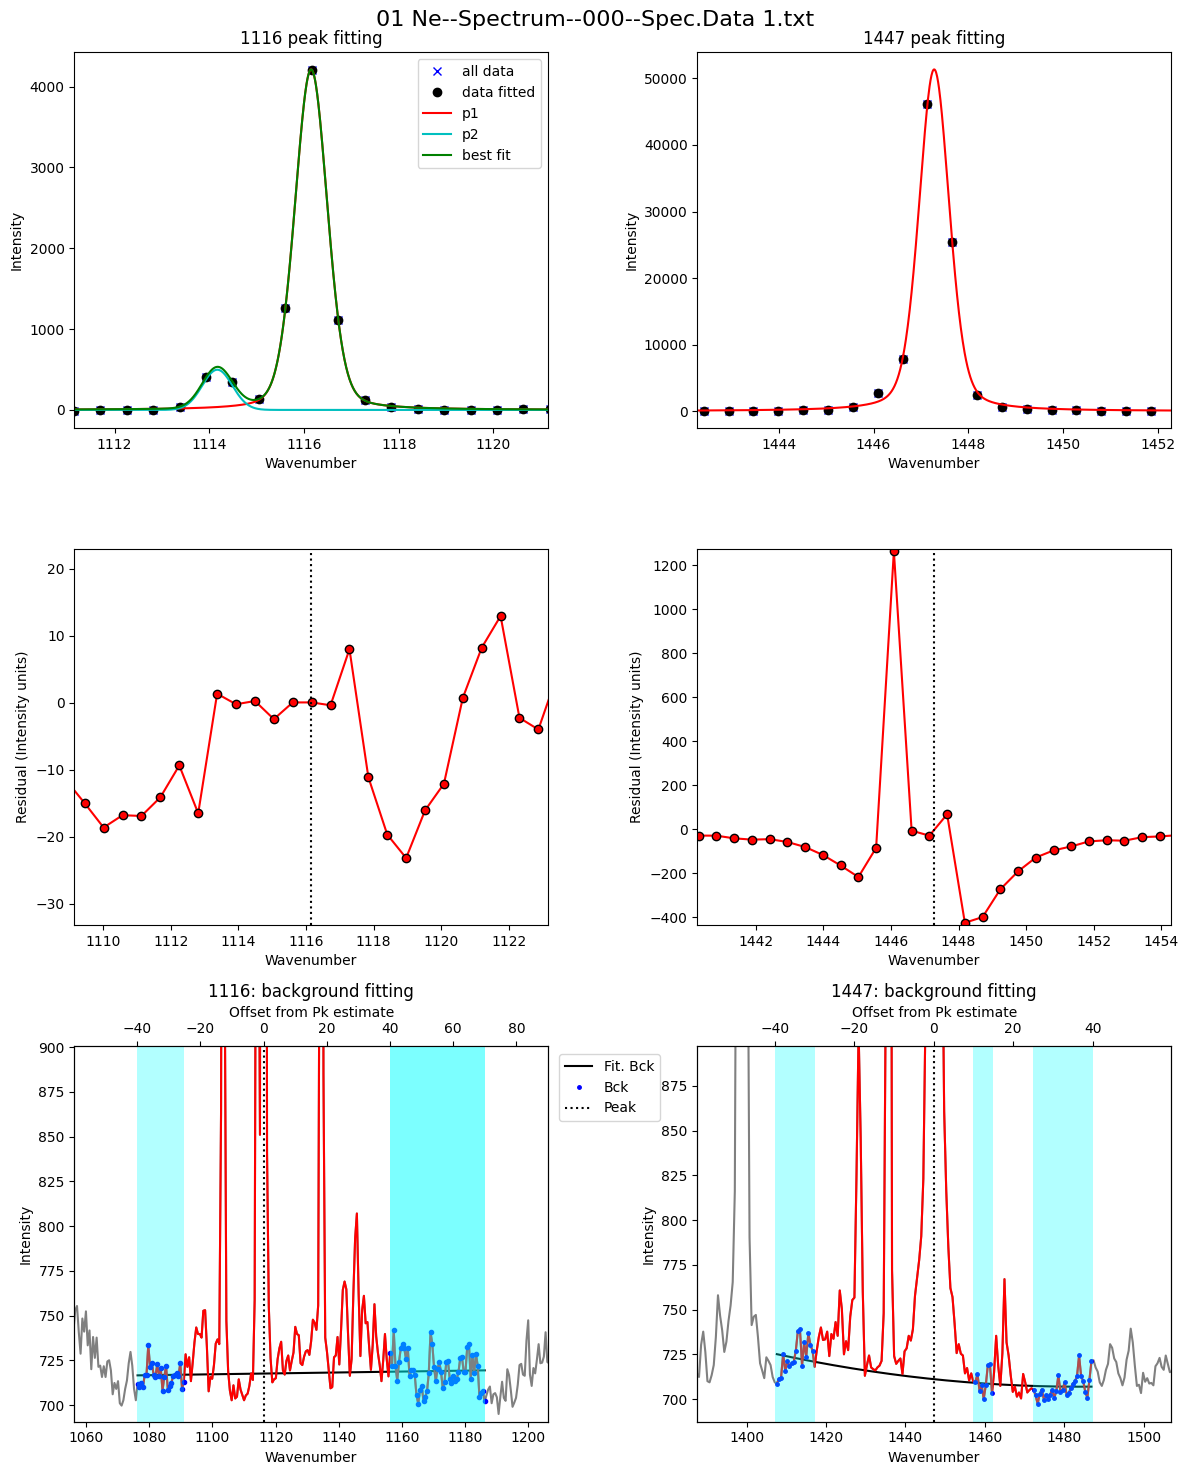

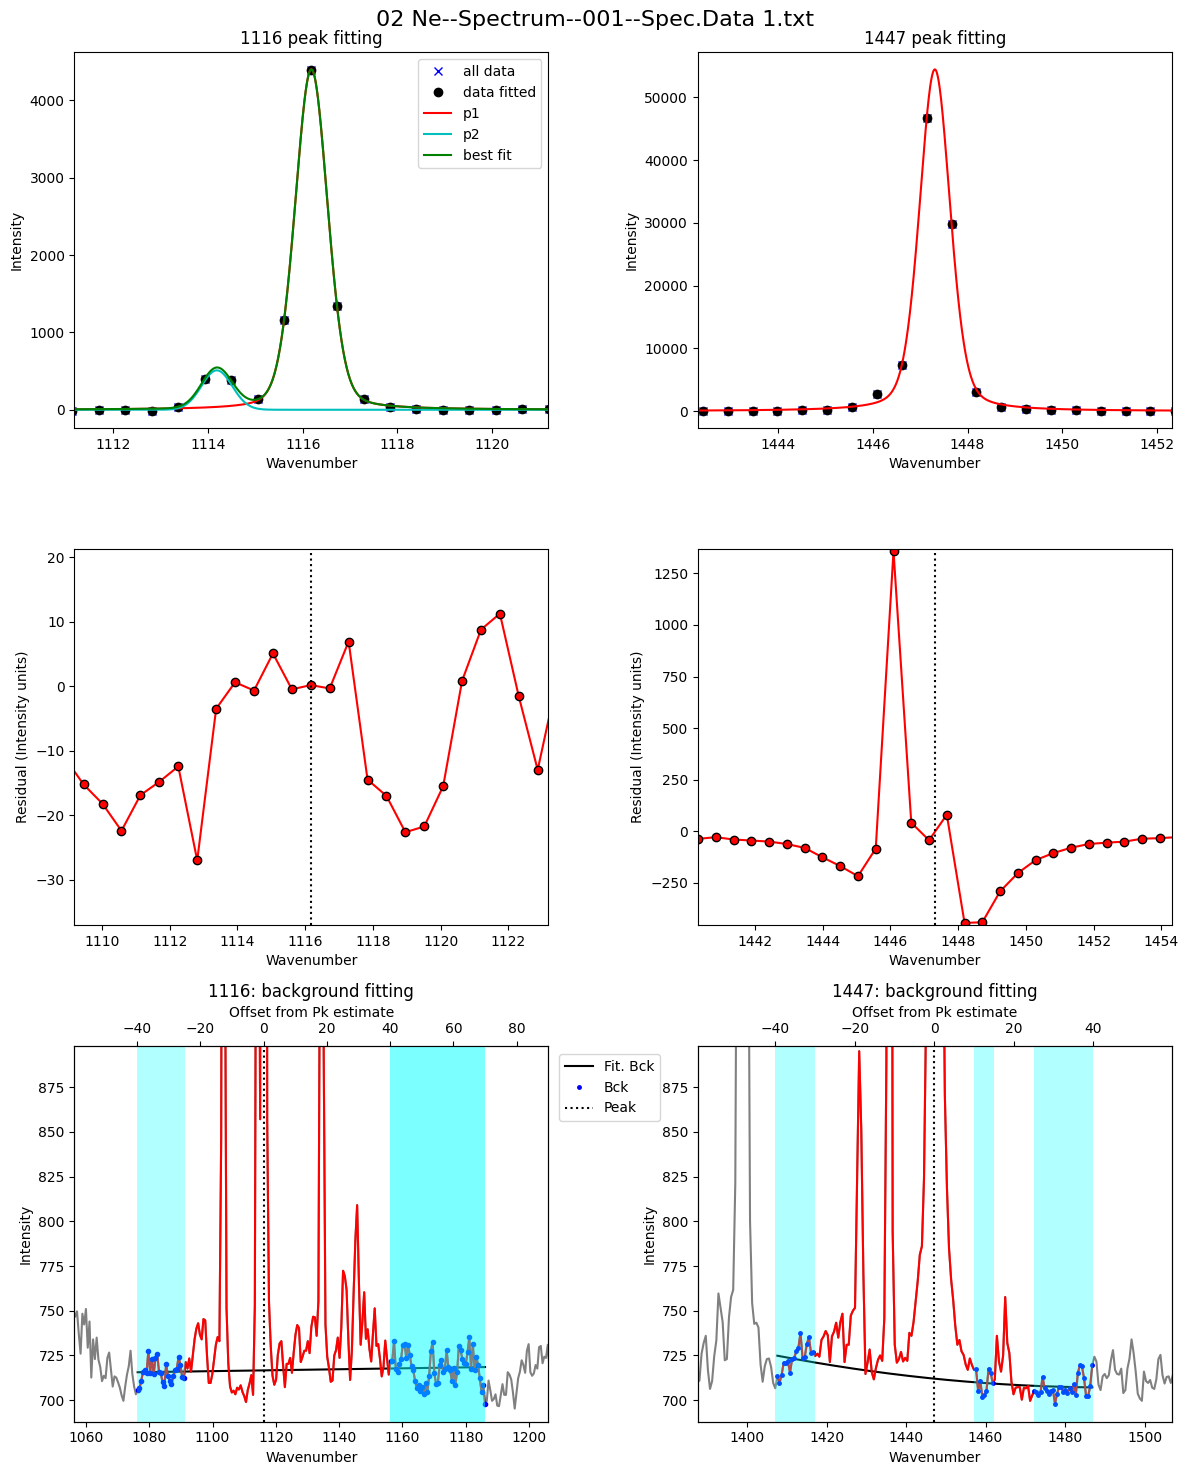

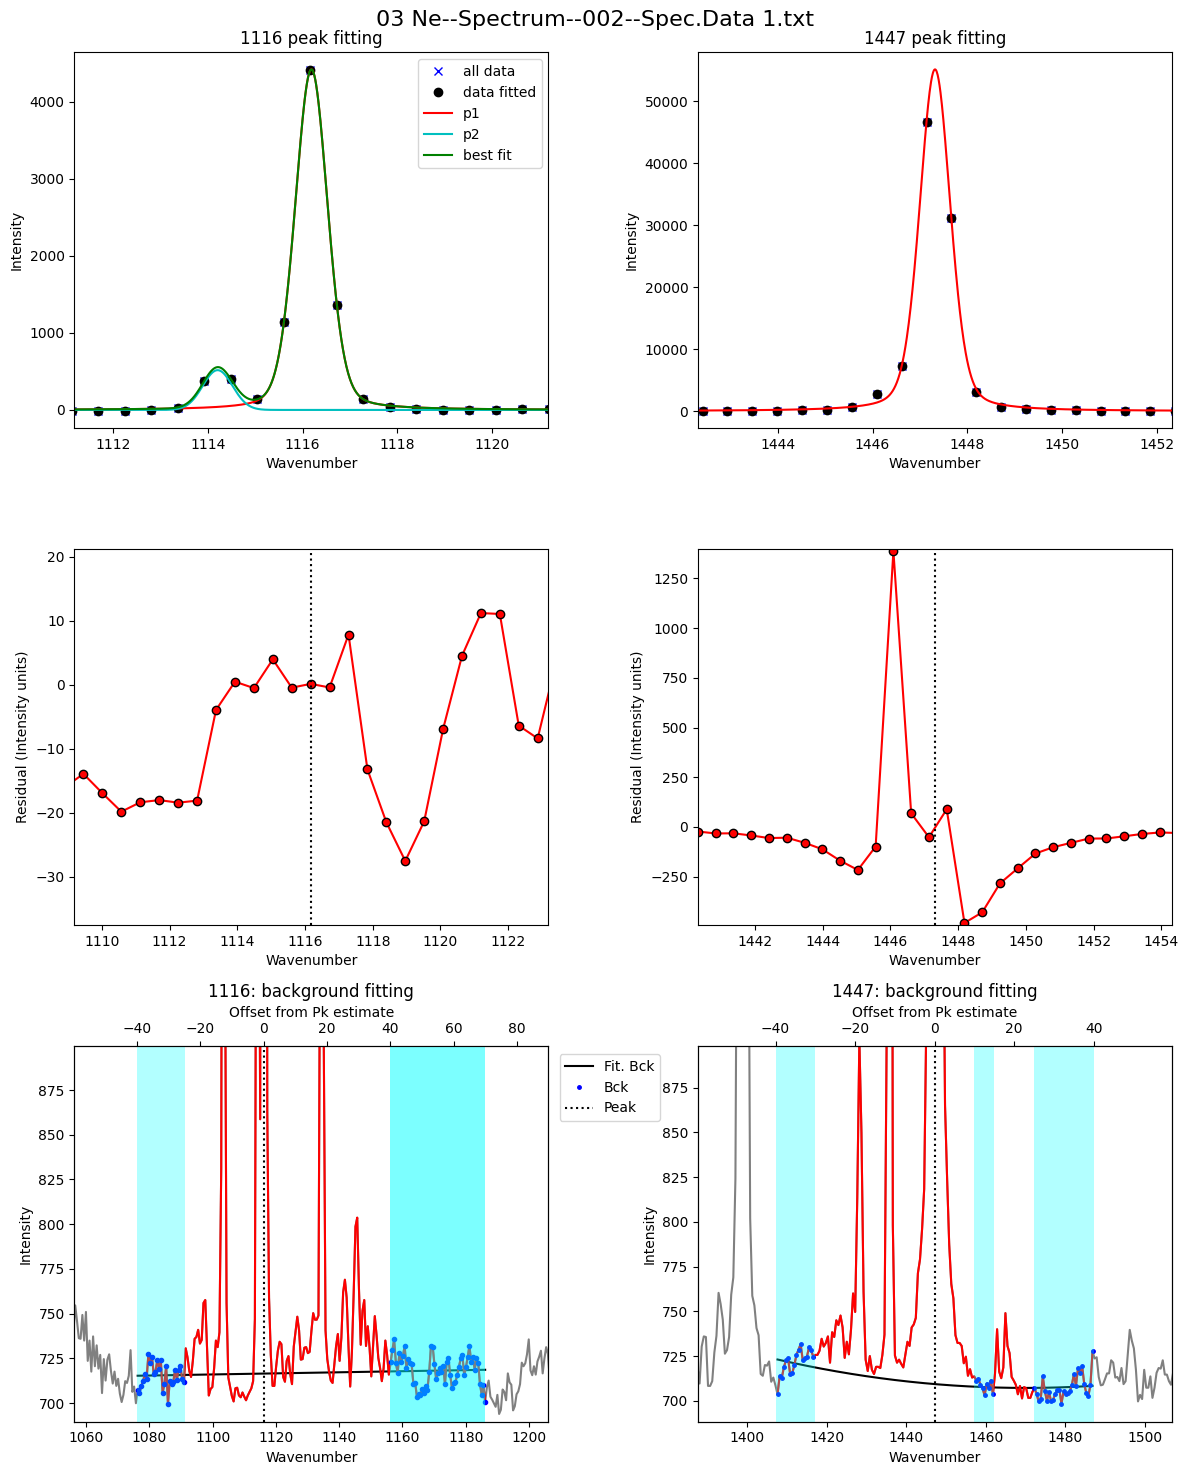

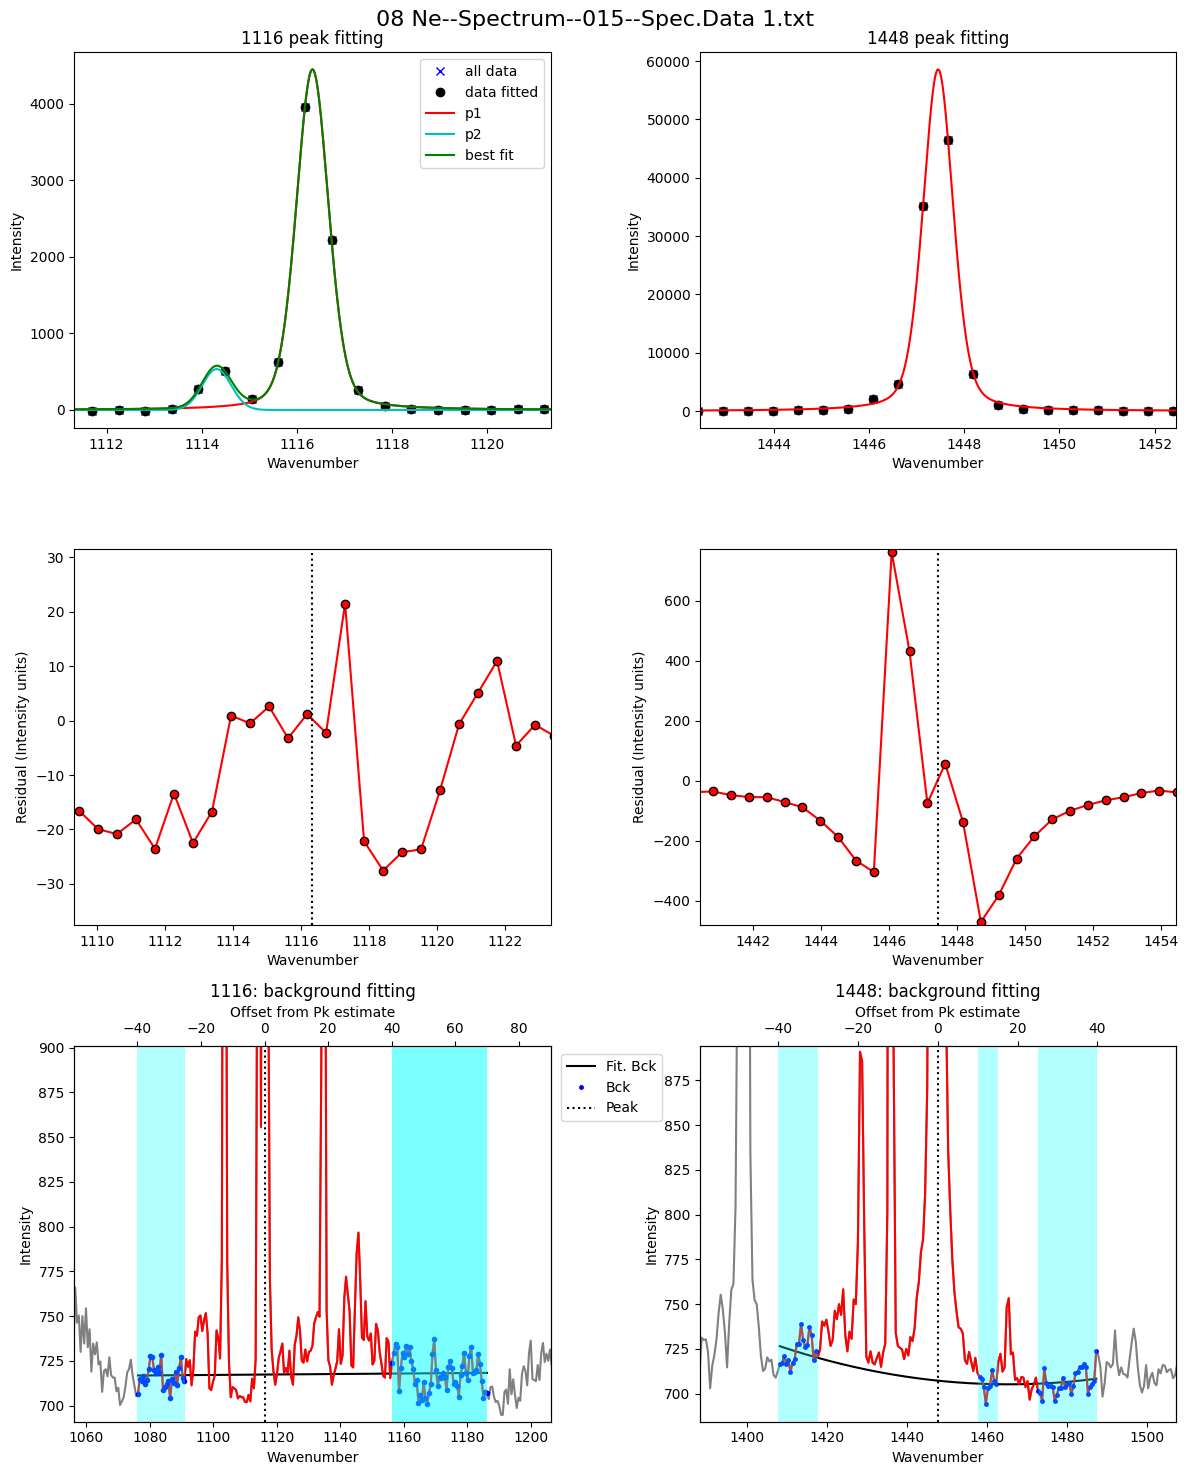

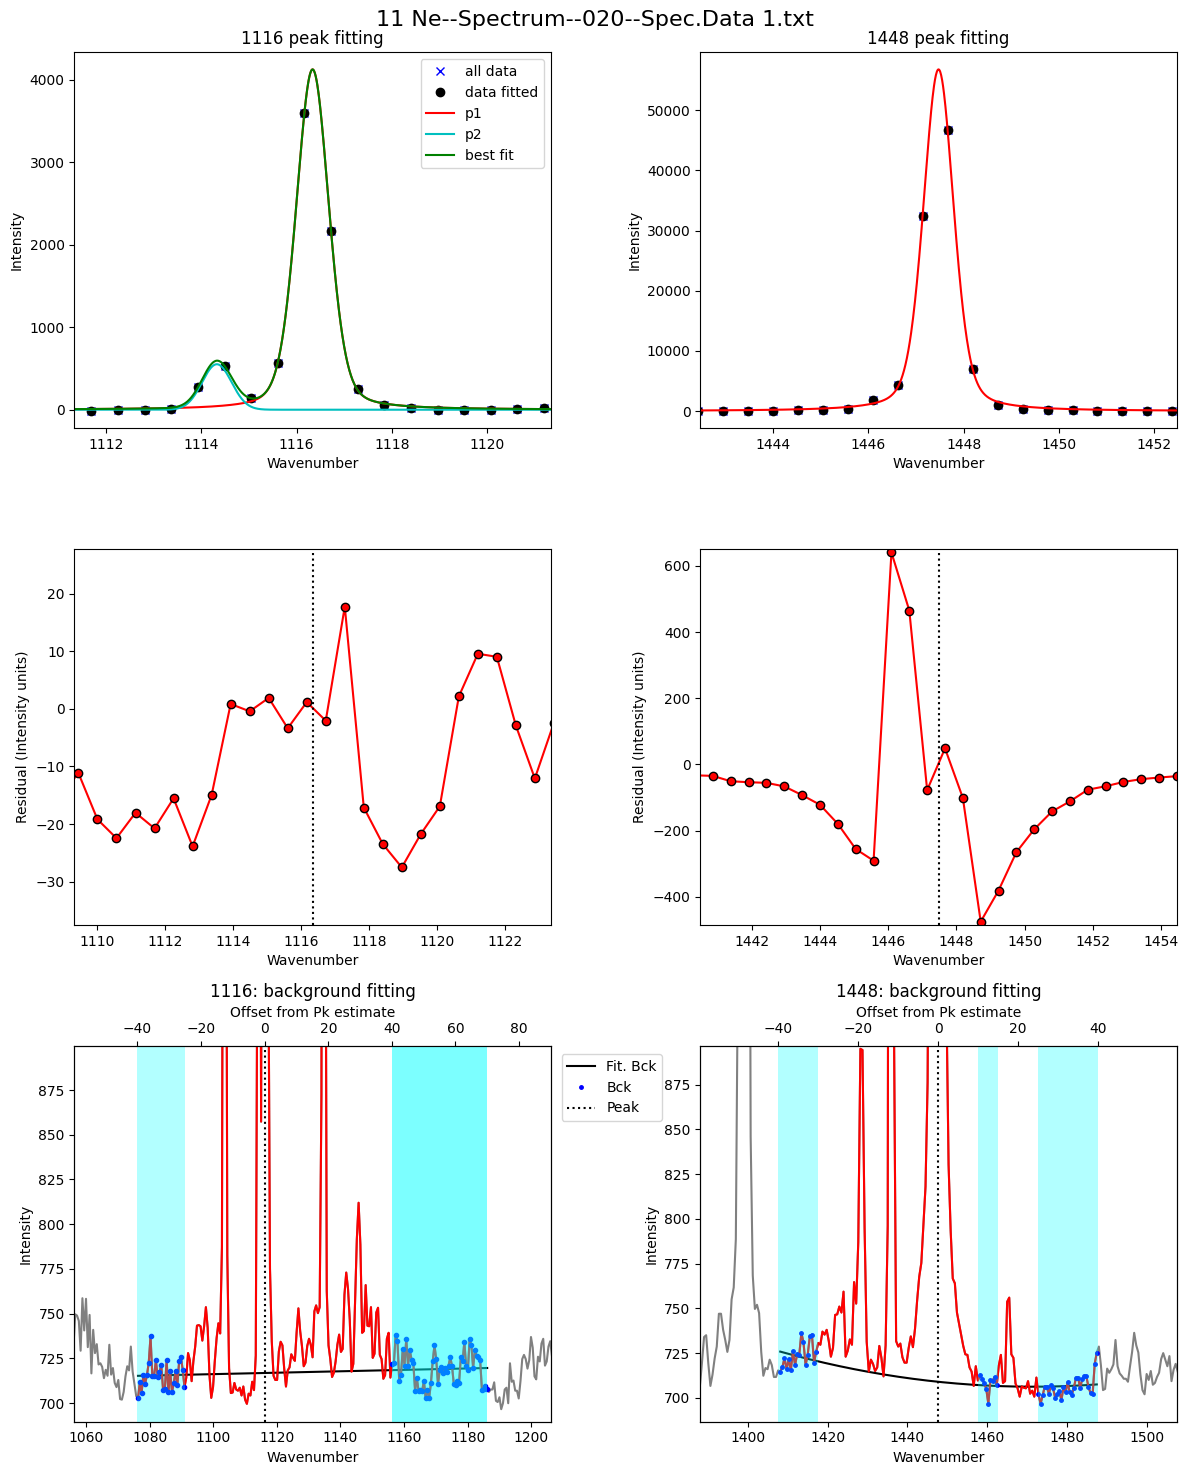

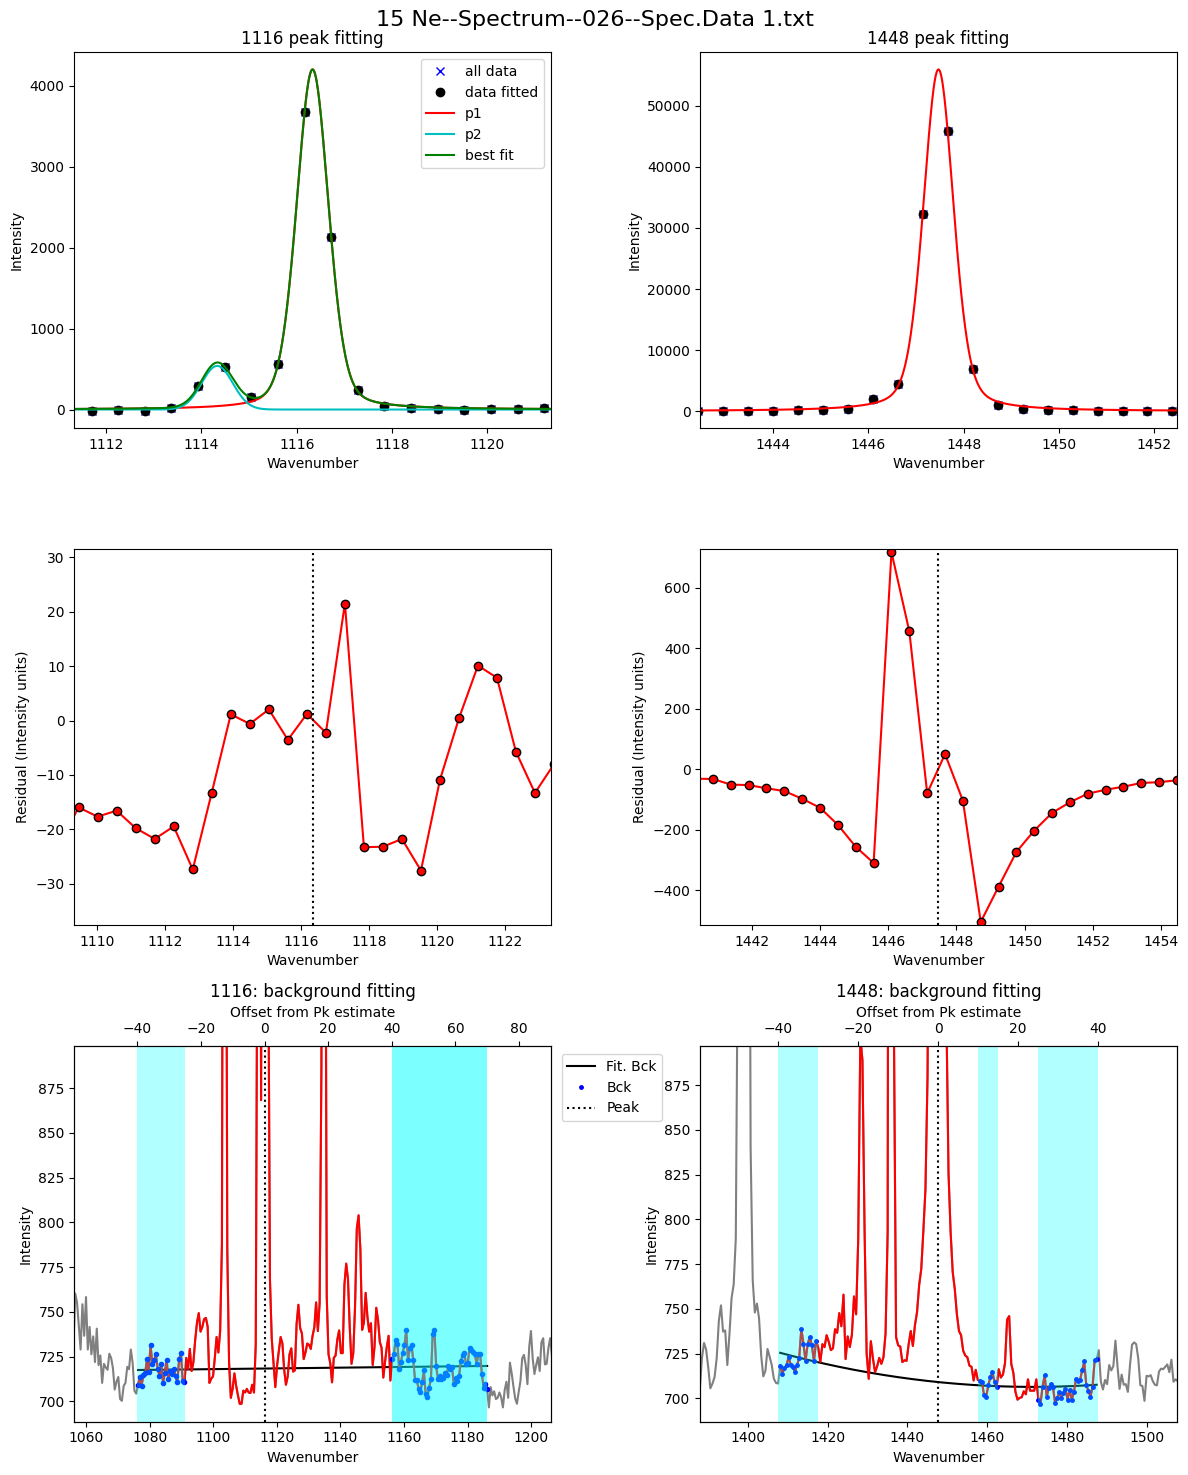

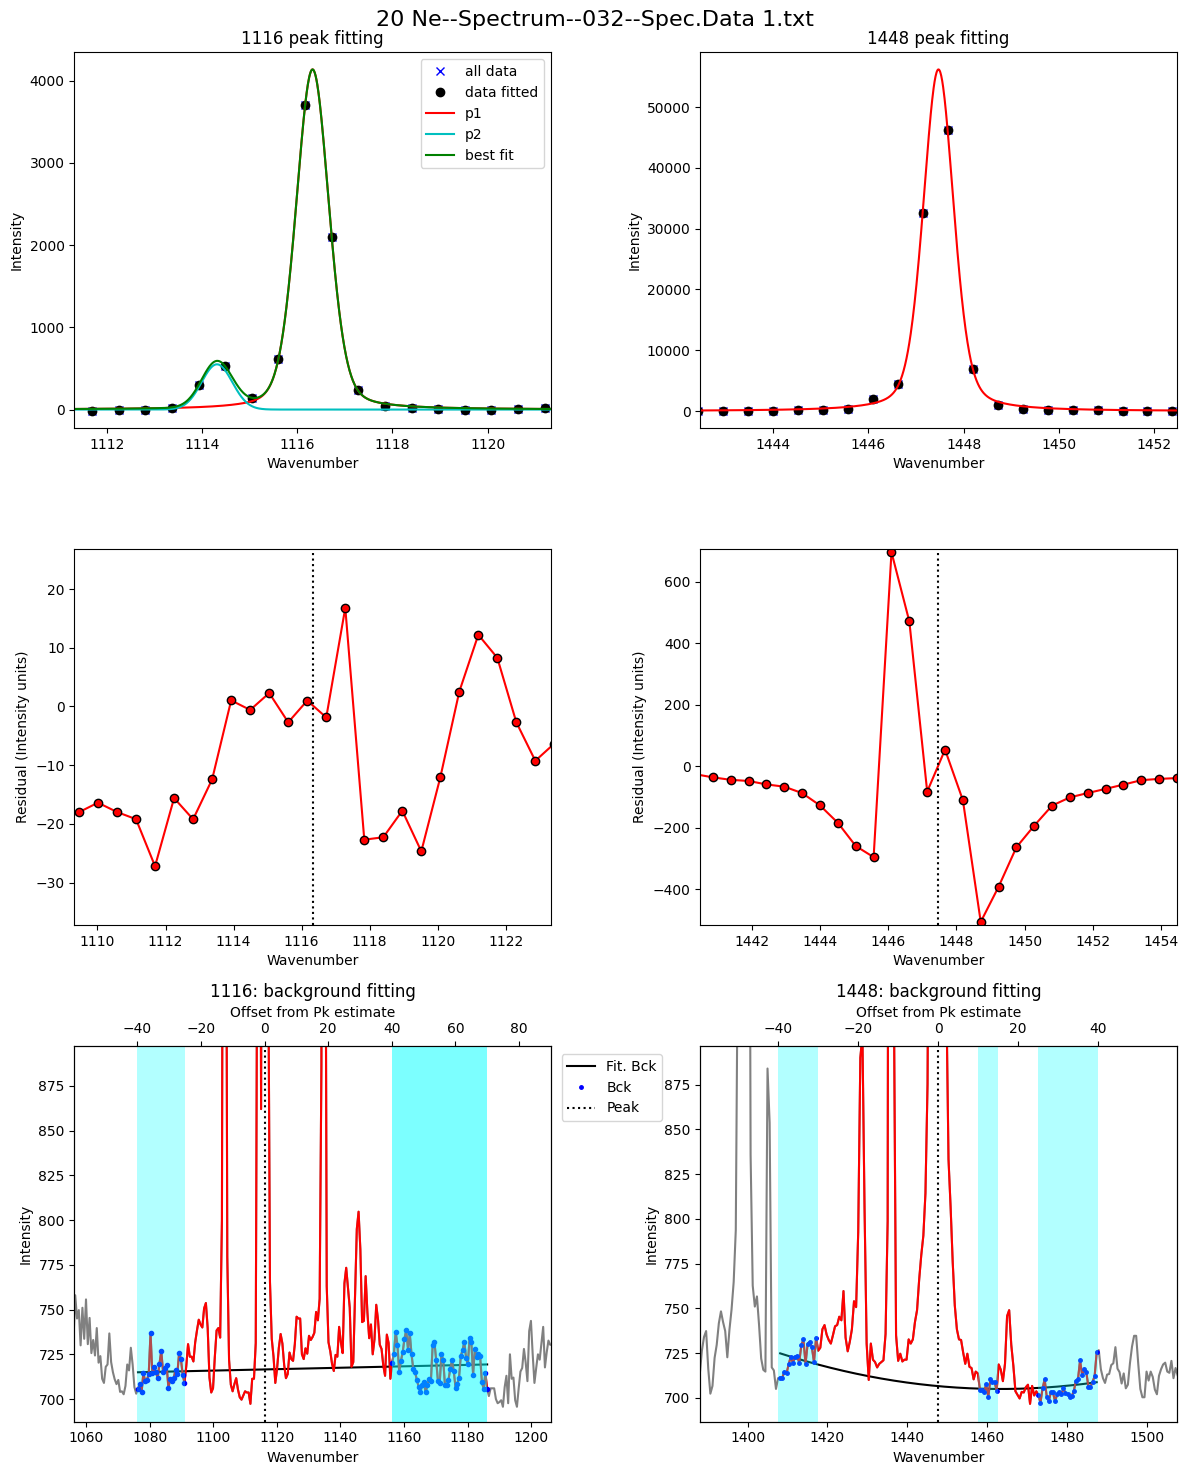

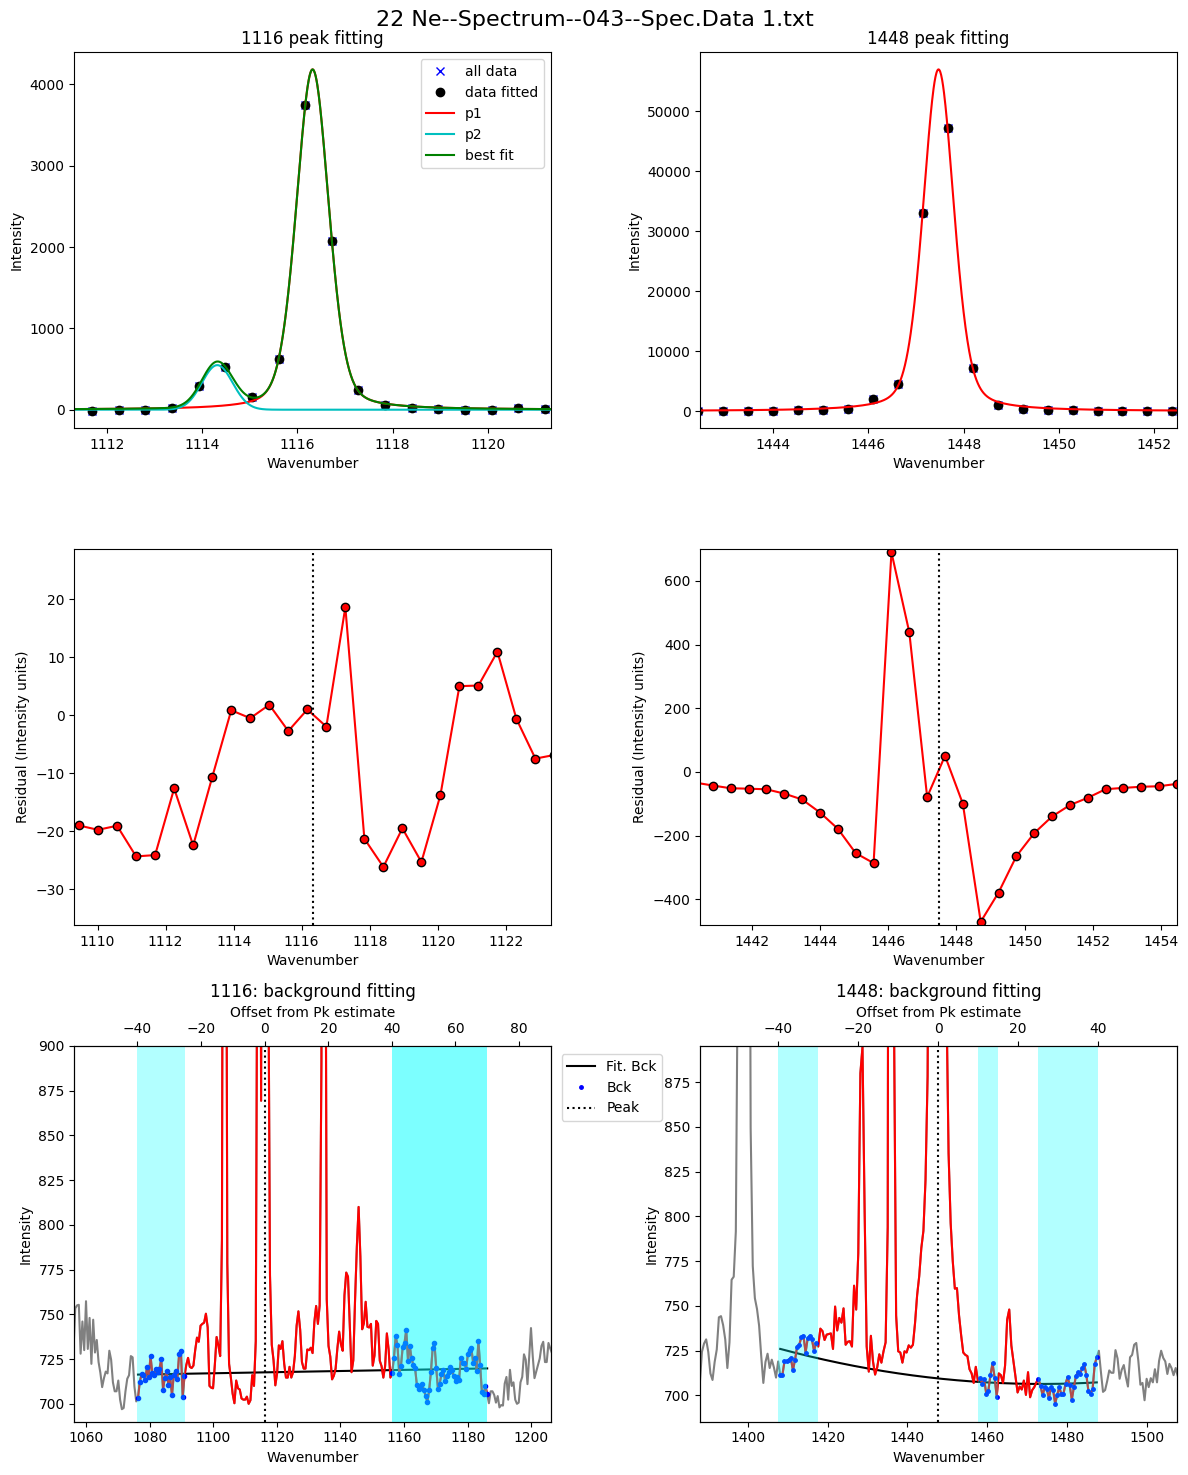

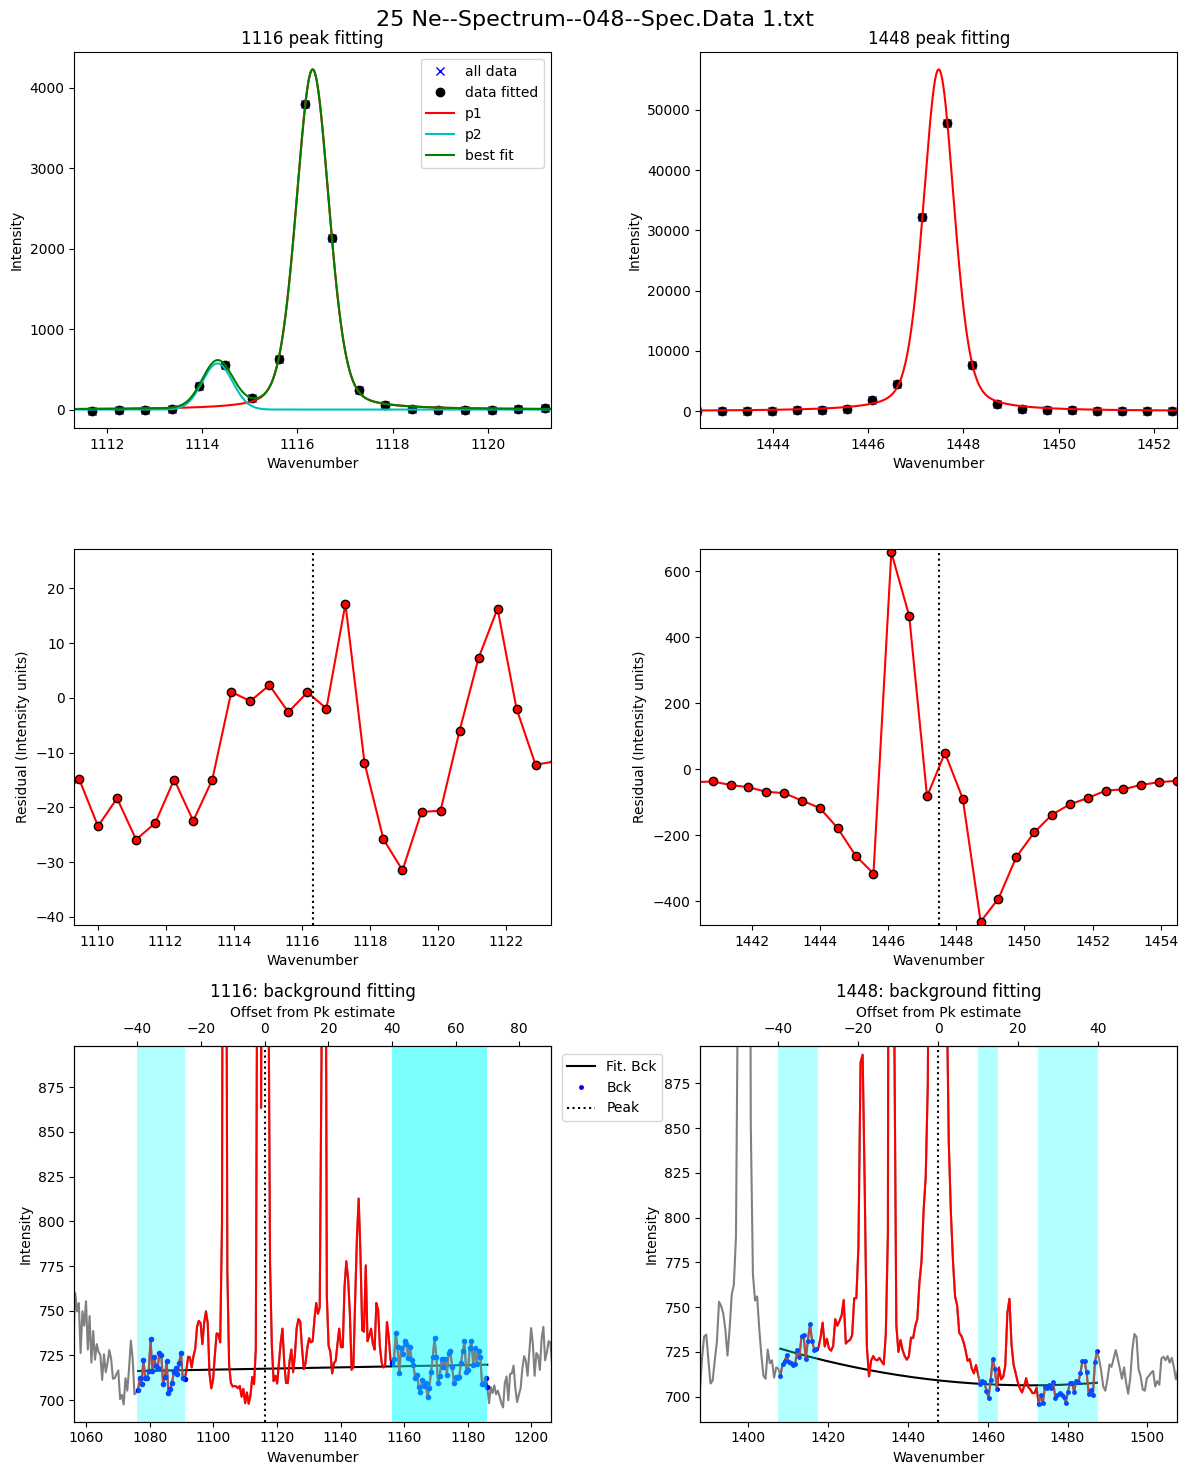

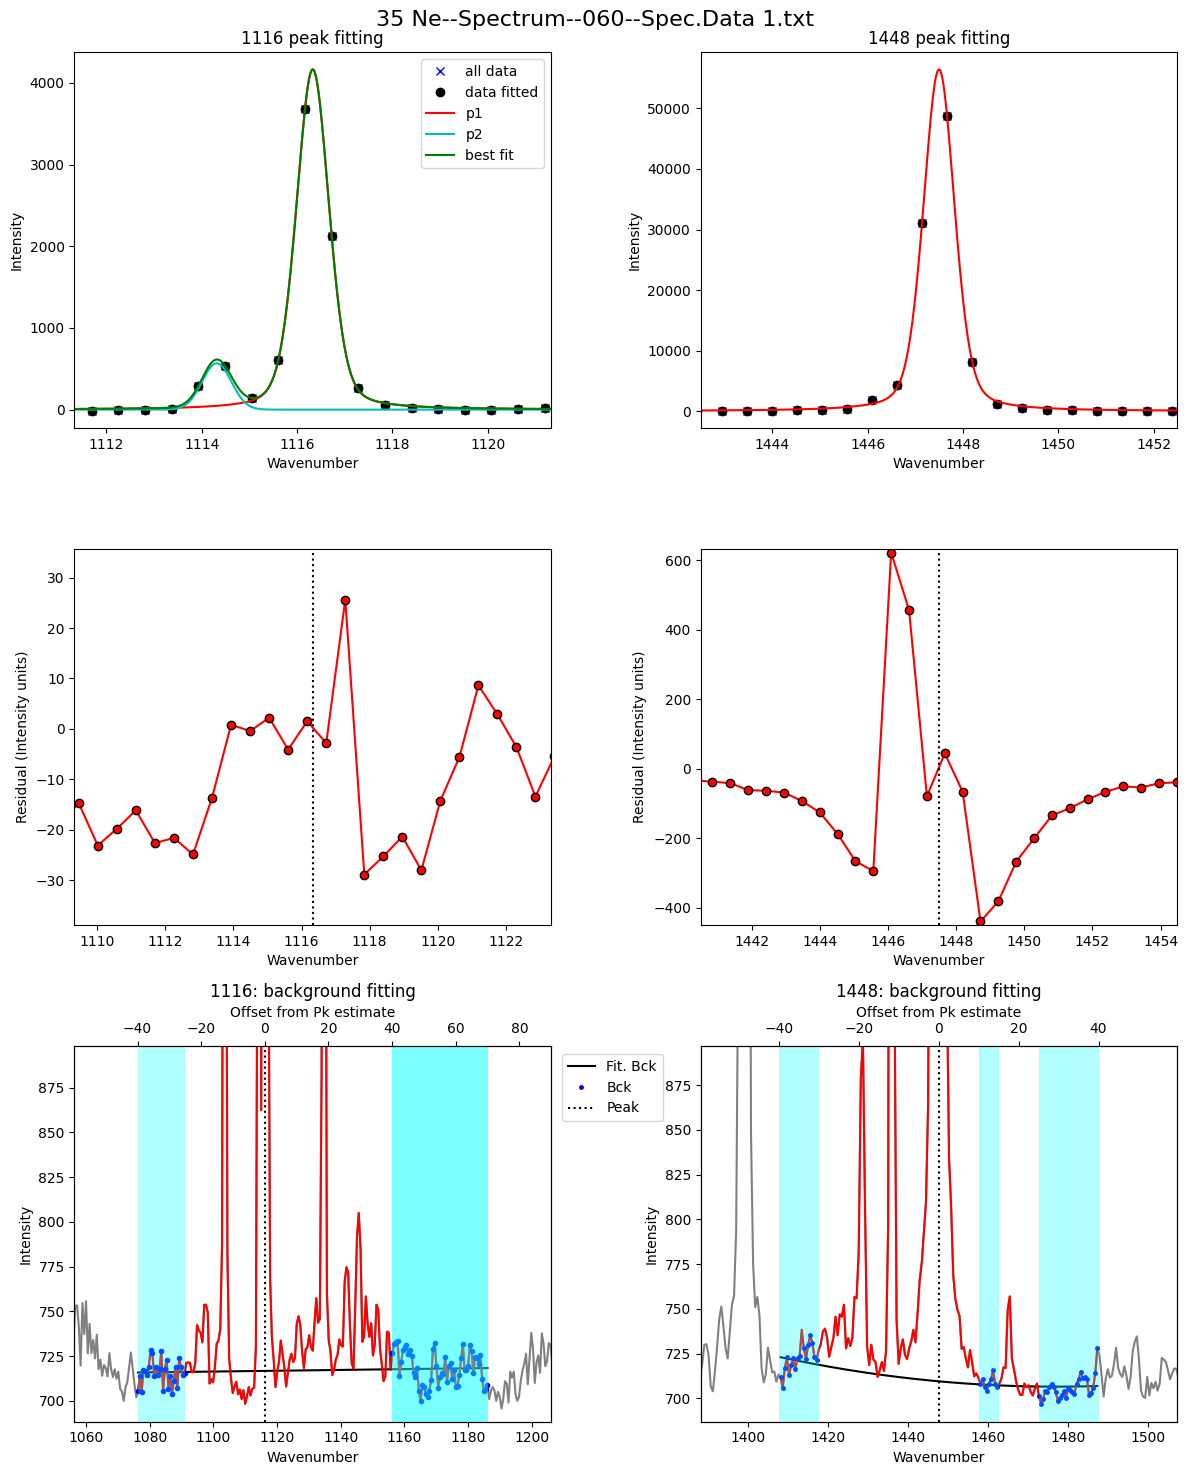

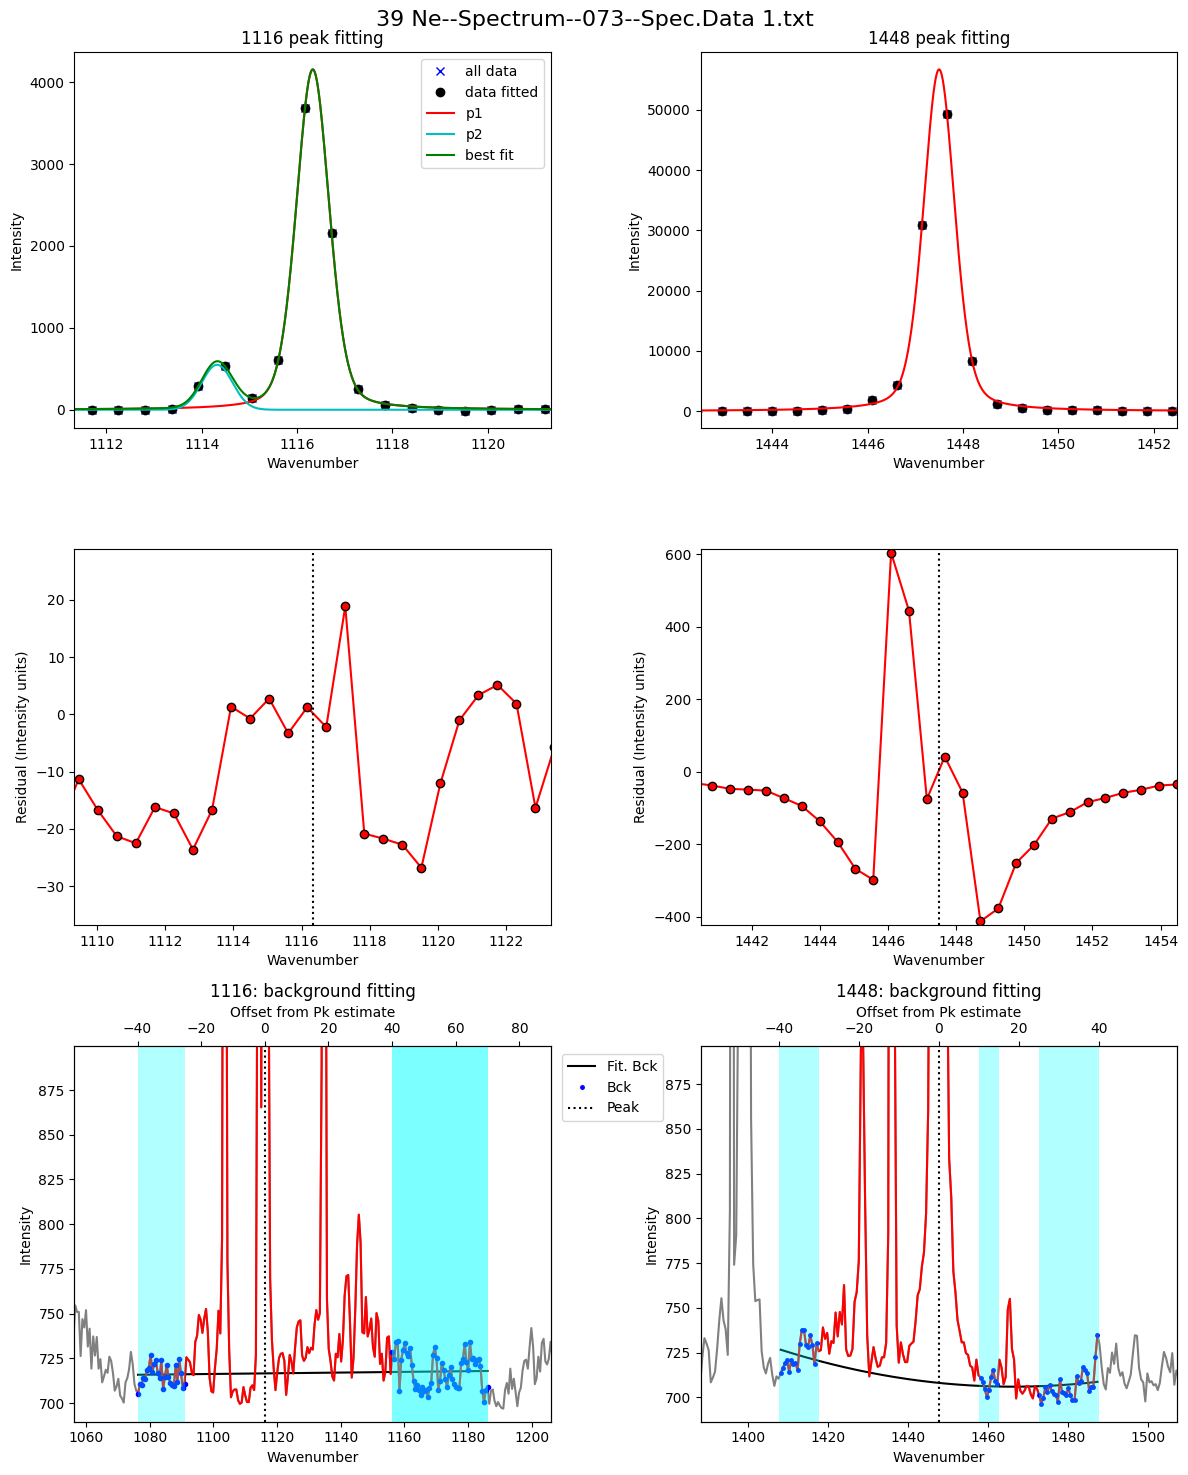

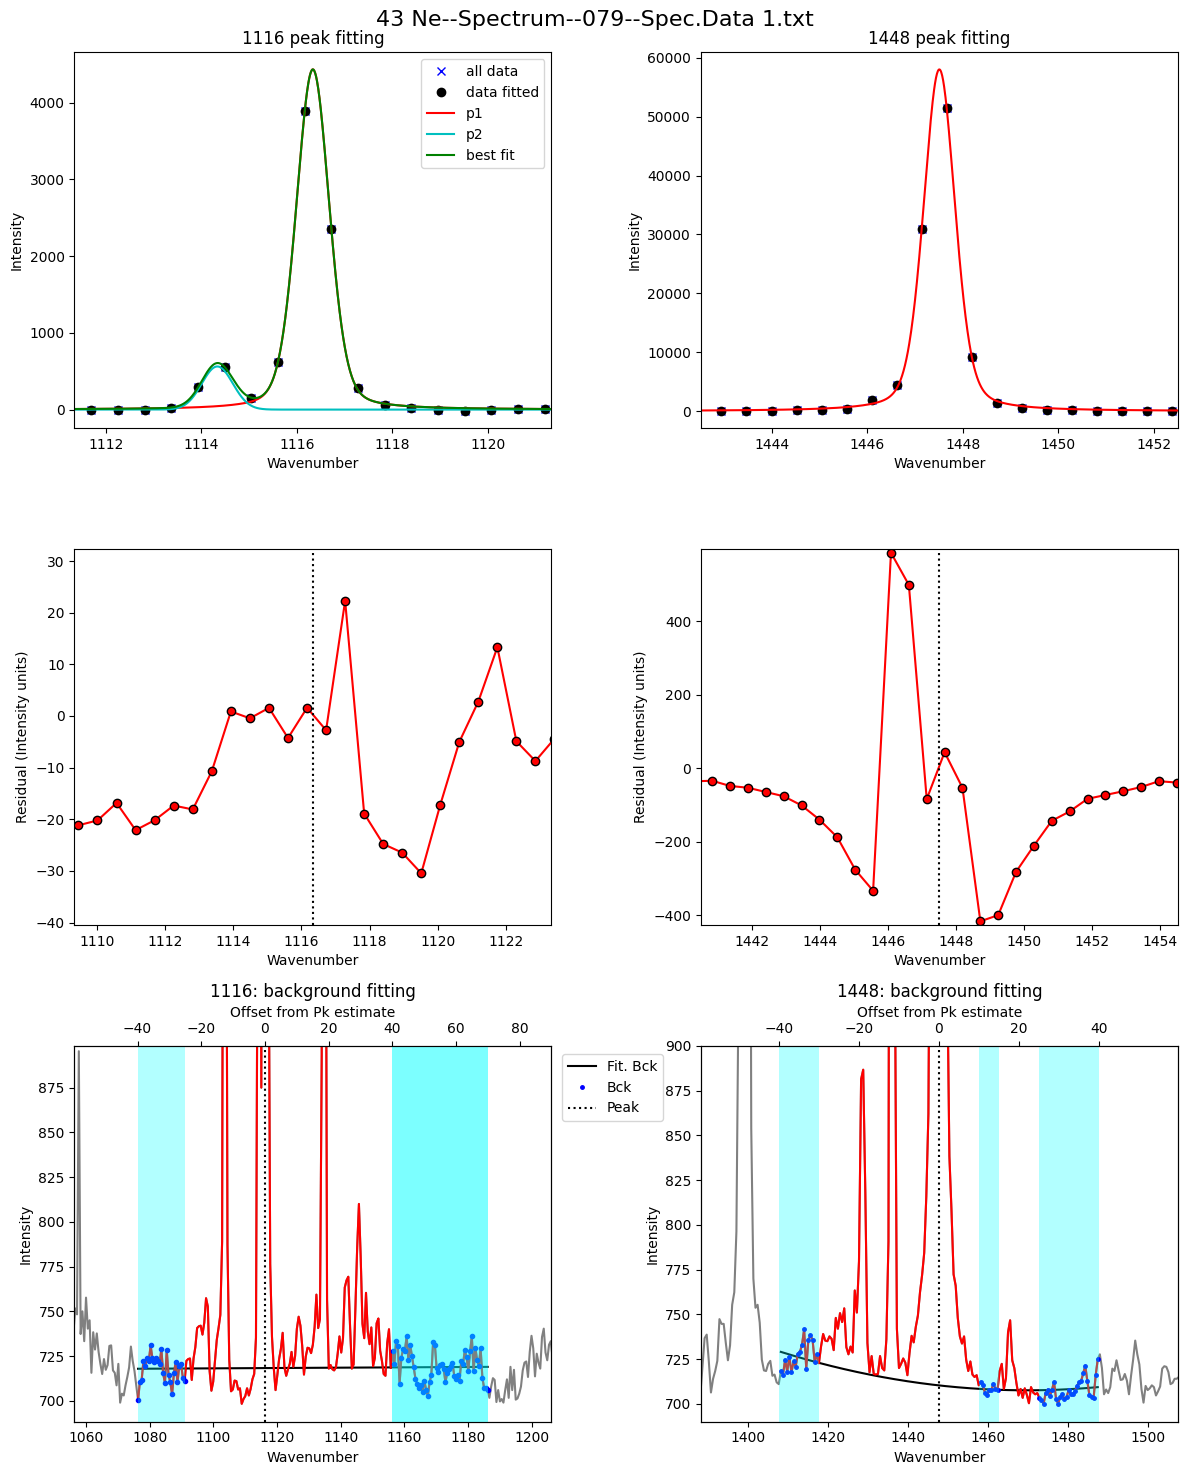

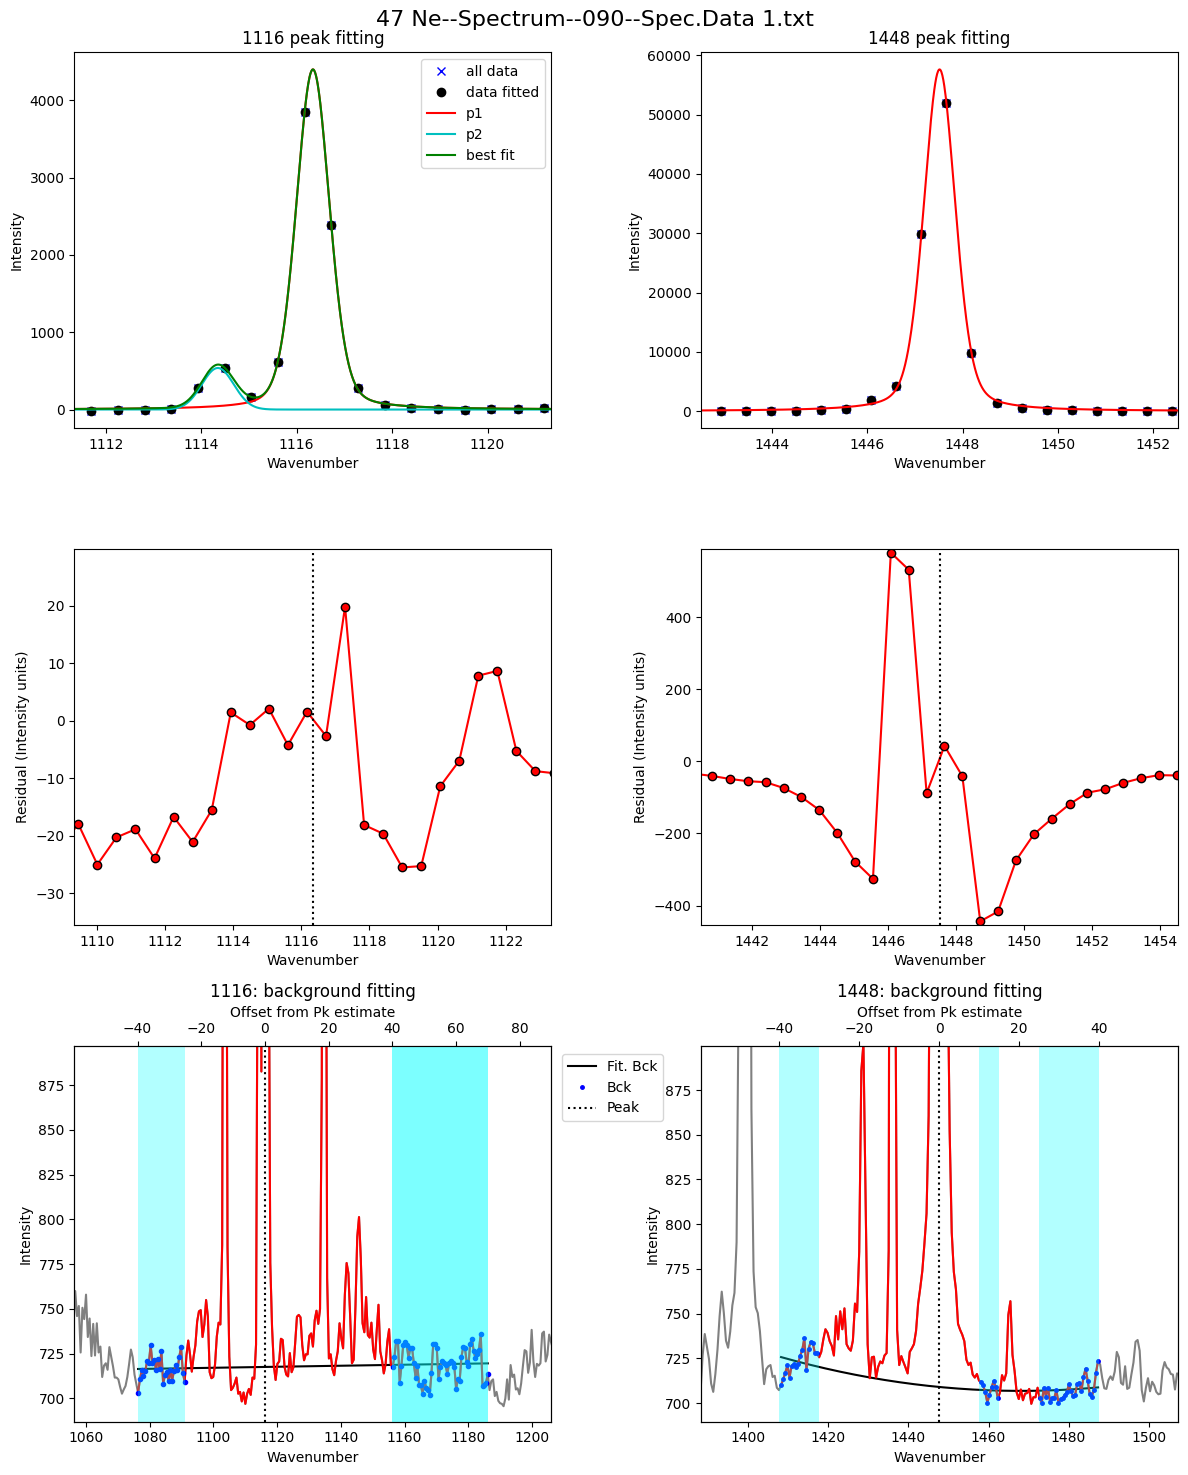

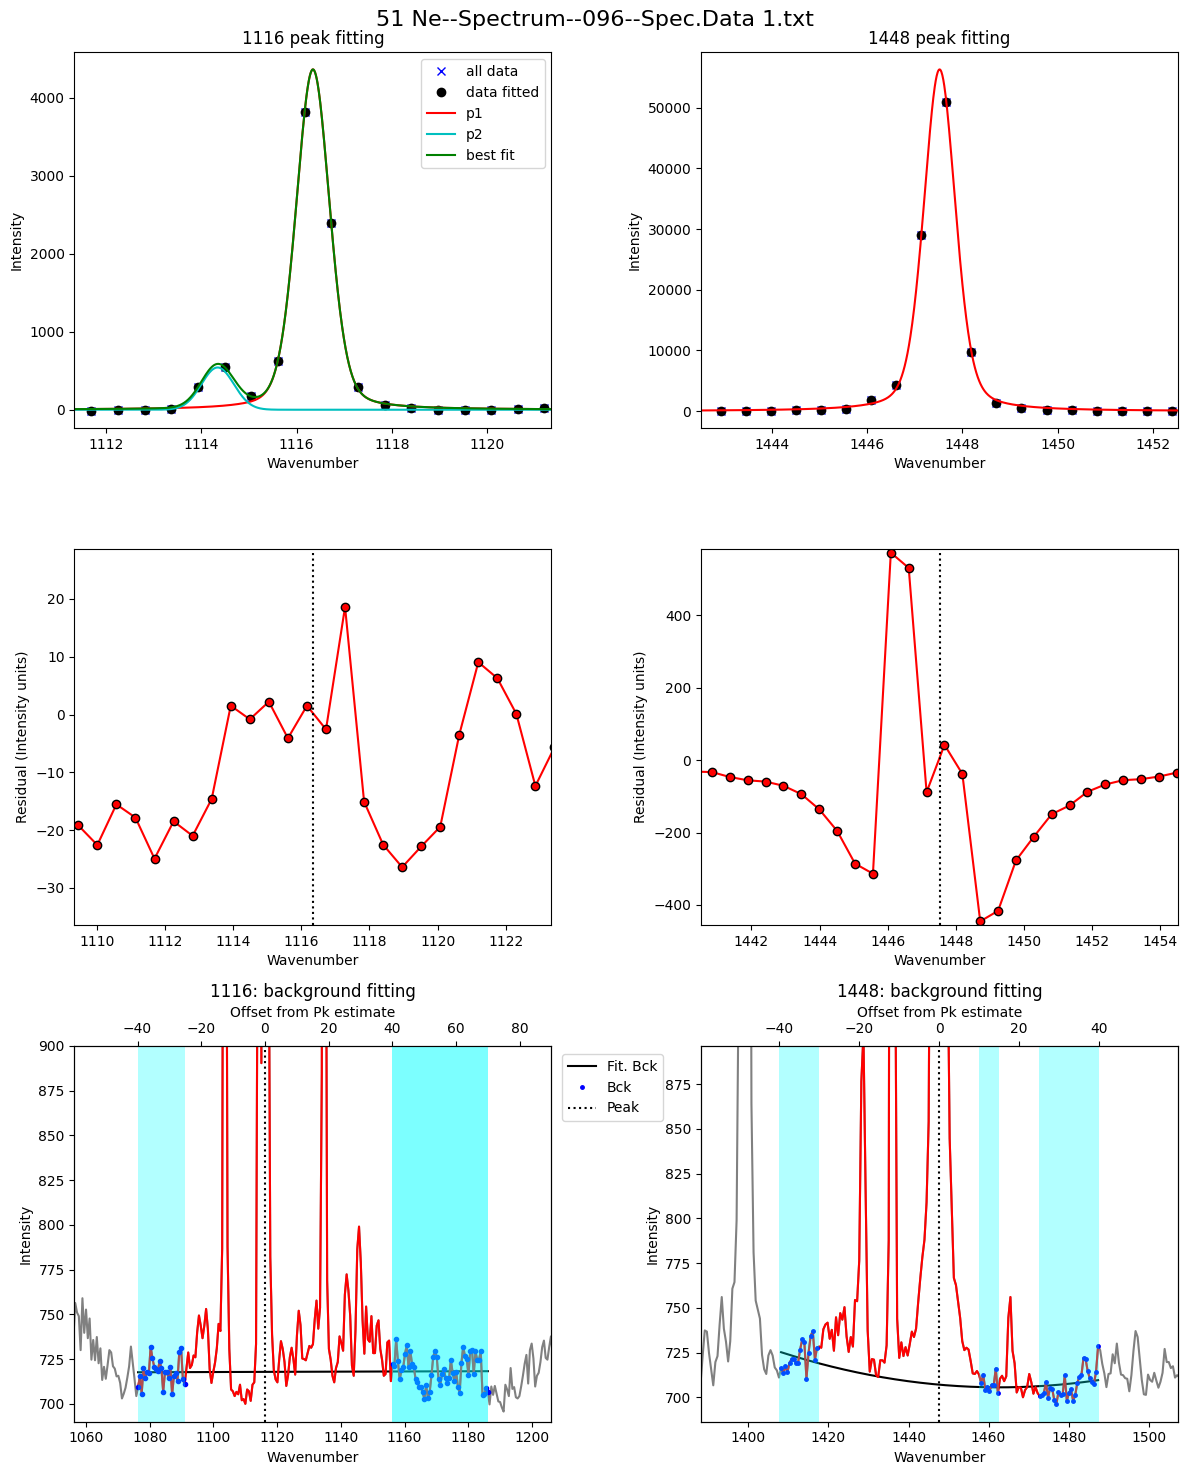

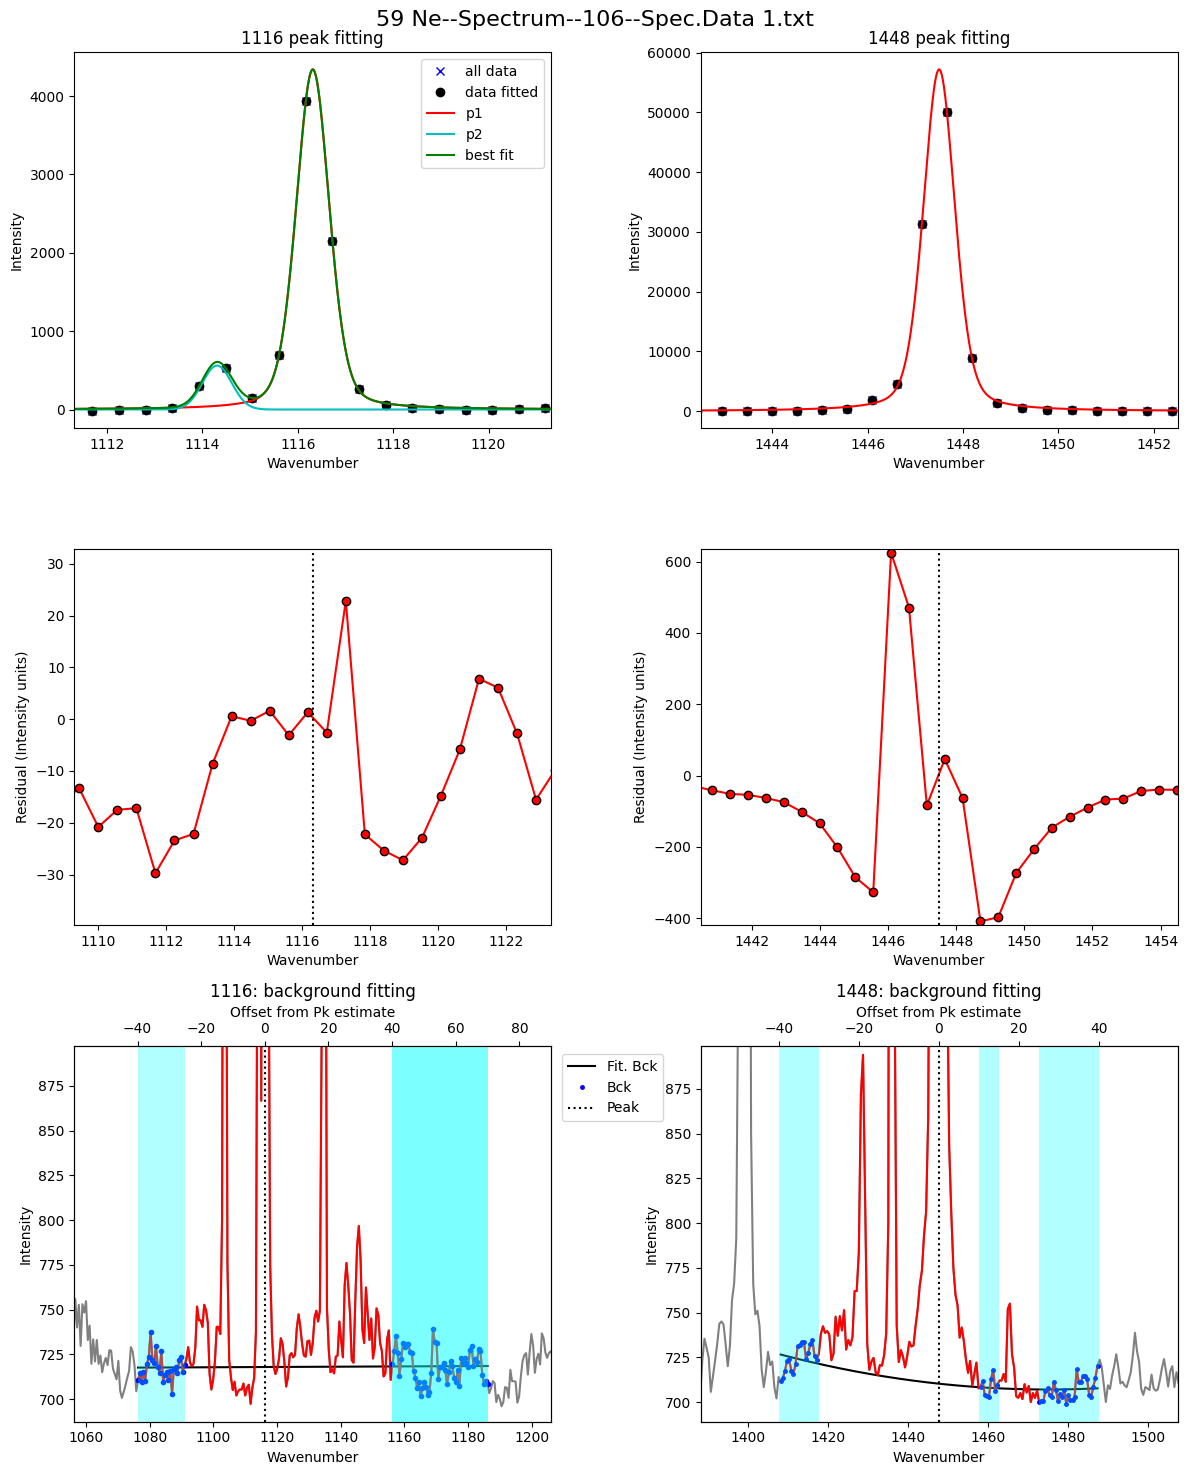

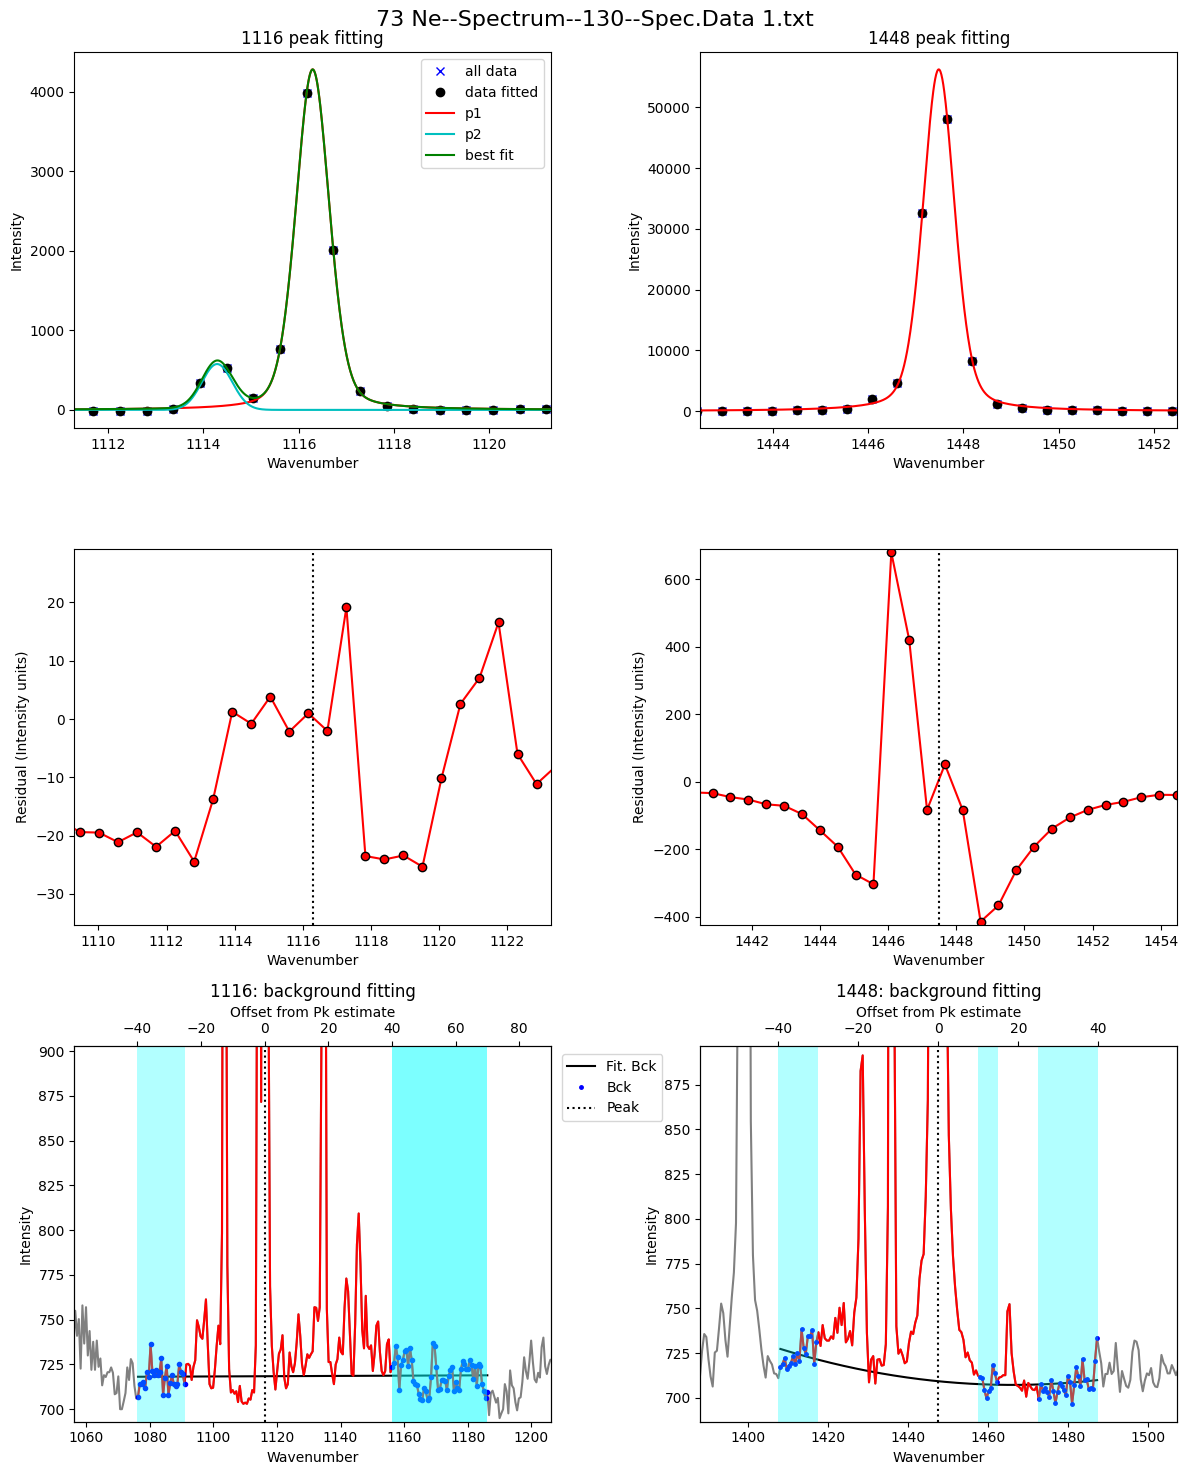

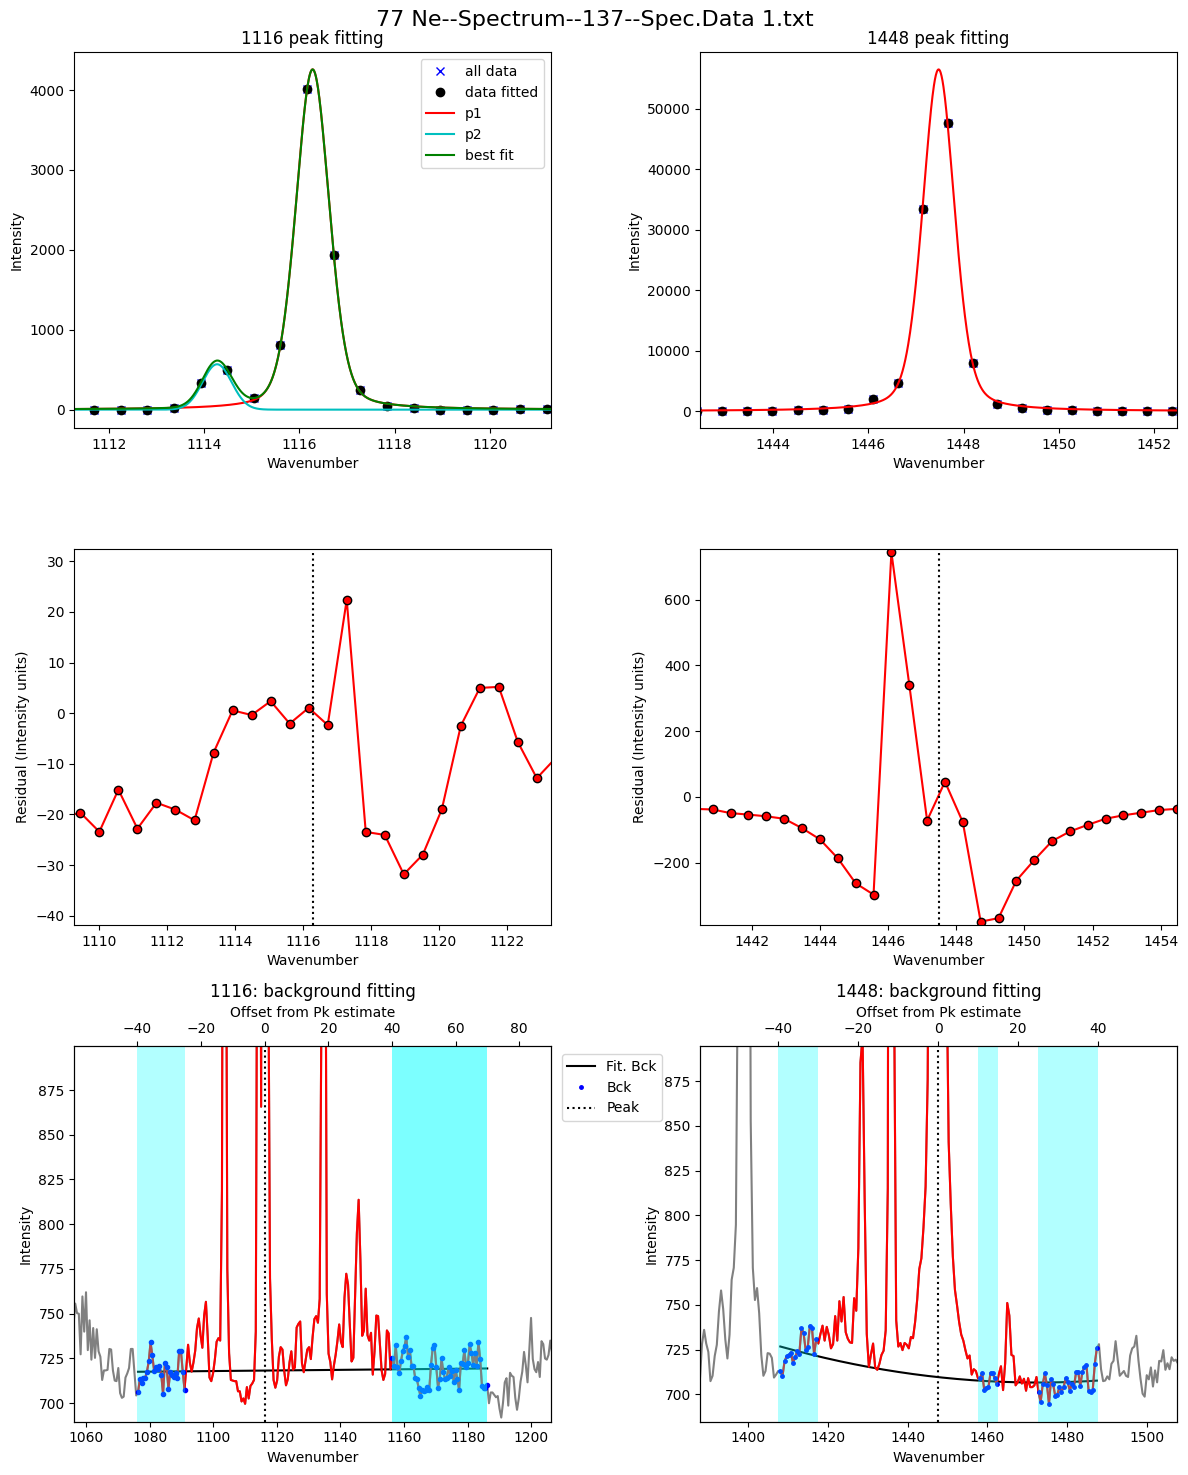

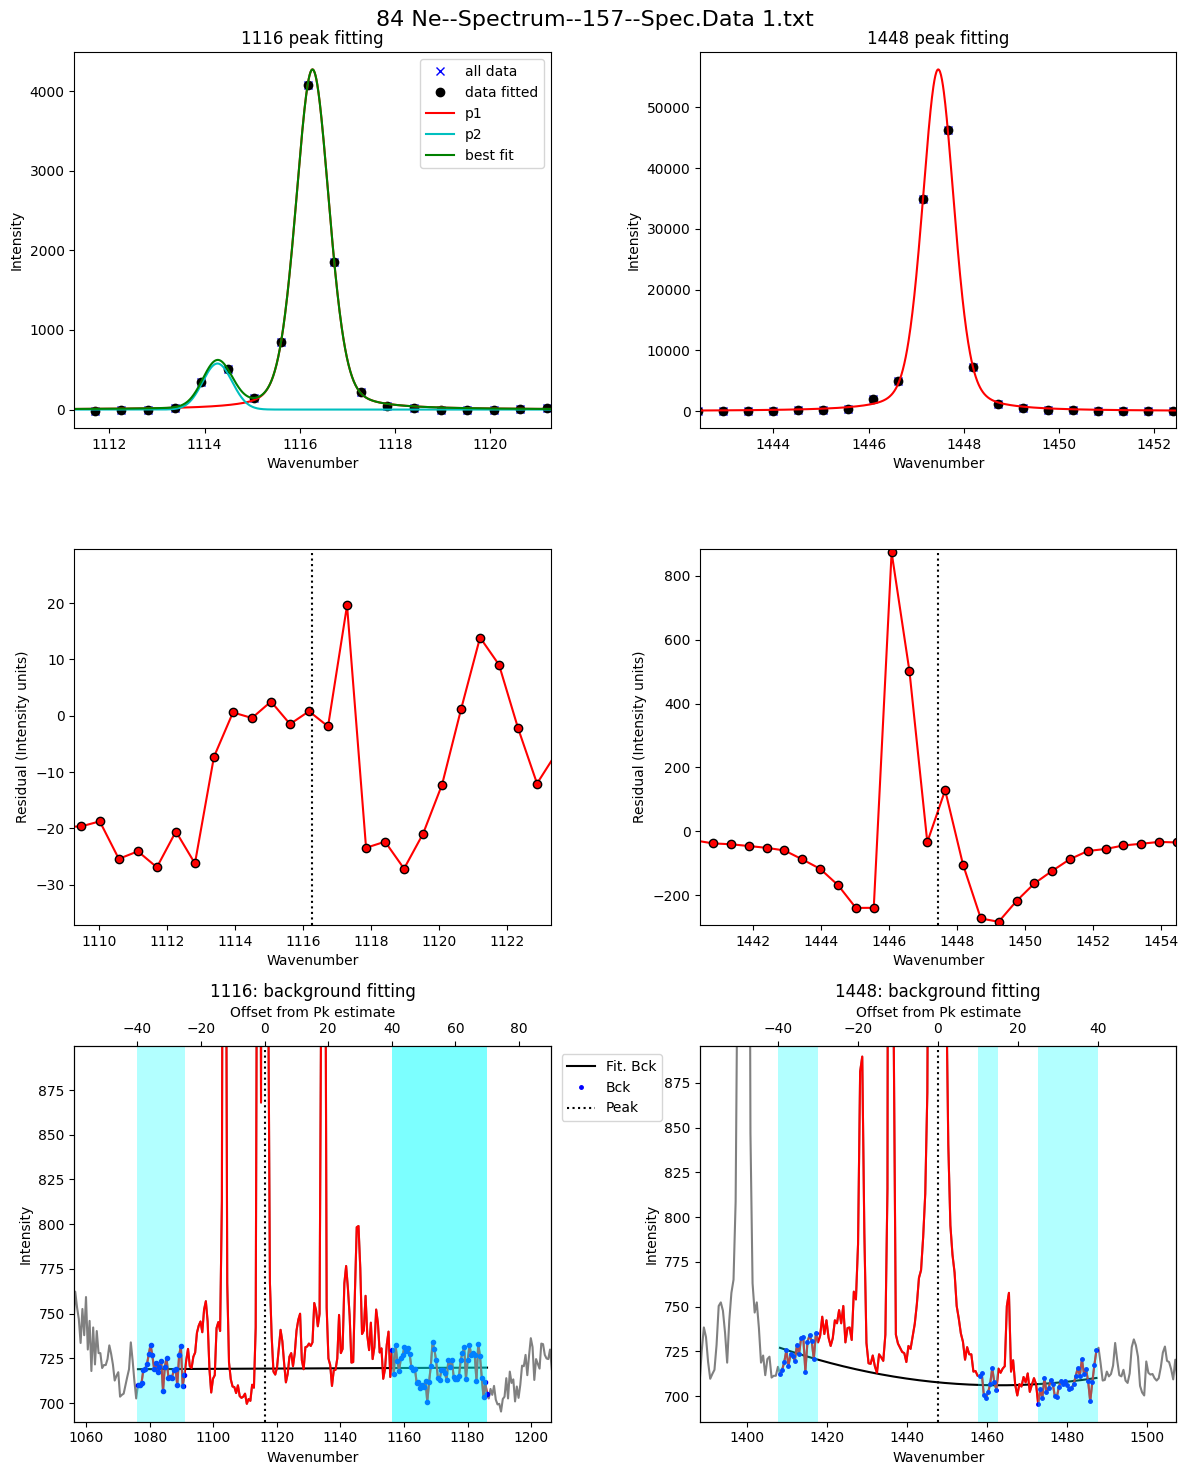

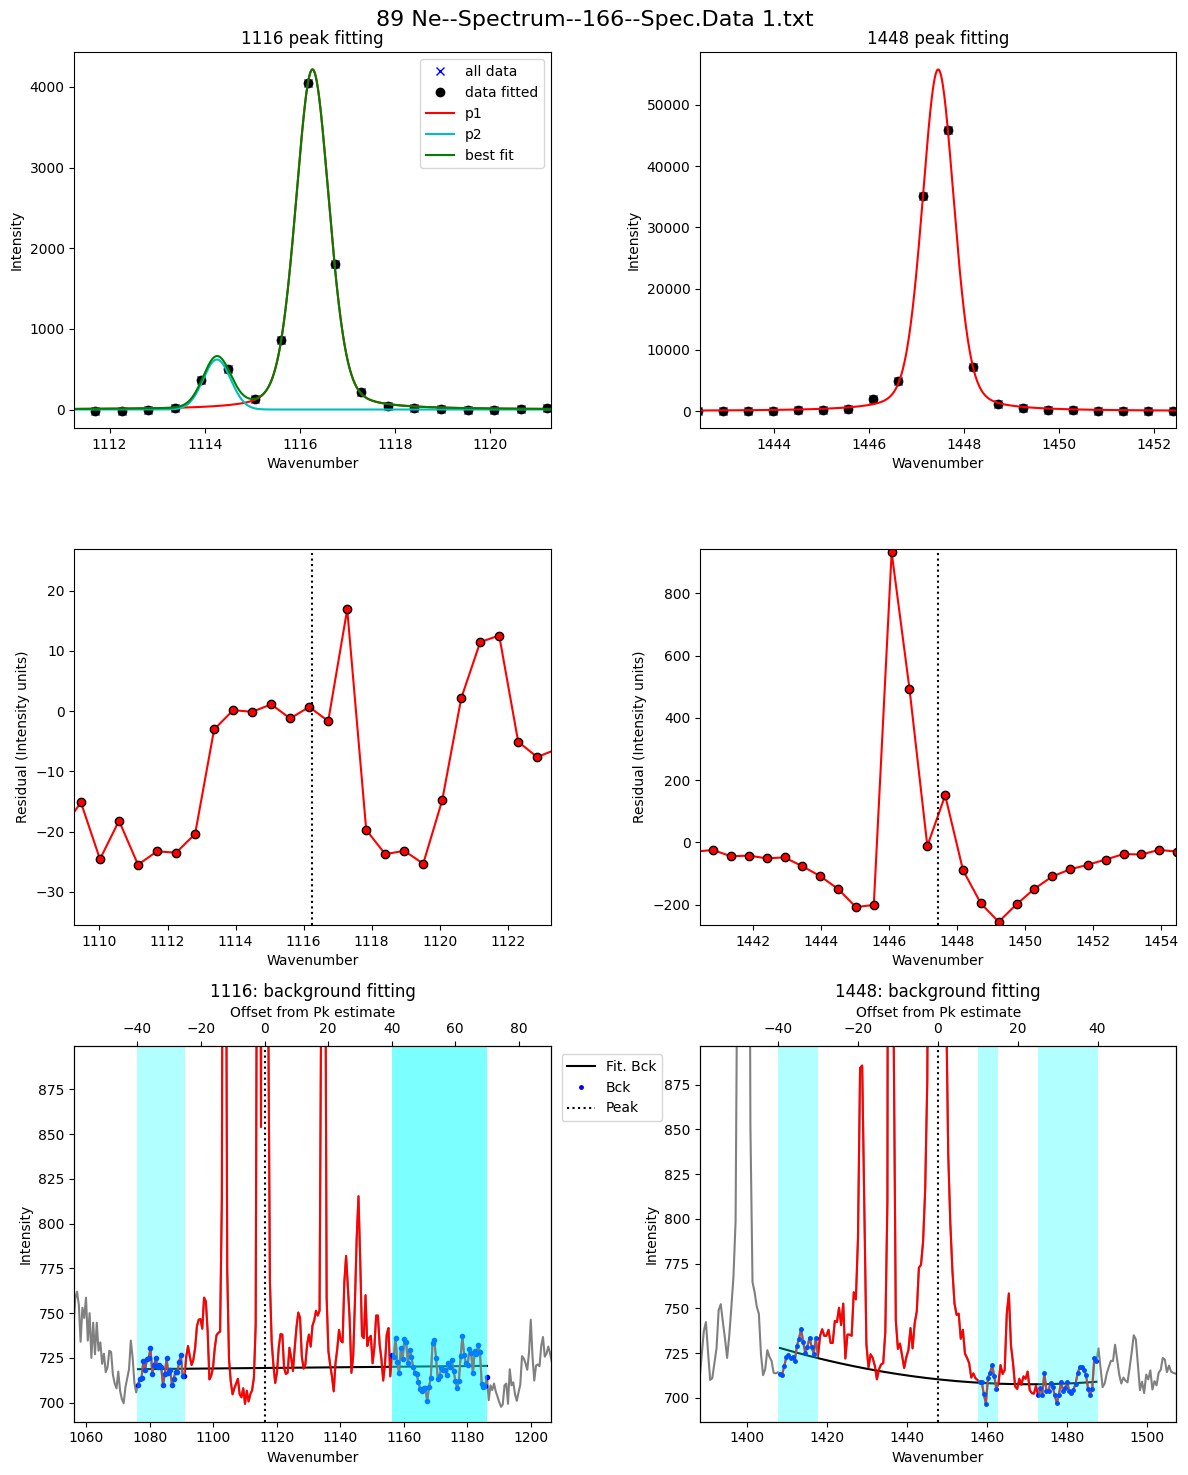

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--000--Spec.Data 1.txt  0.998030    0.000038  331.129921   
1   Ne--Spectrum--001--Spec.Data 1.txt  0.998039    0.000036  331.127042   
2   Ne--Spectrum--002--Spec.Data 1.txt  0.998029    0.000036  331.130188   
3   Ne--Spectrum--015--Spec.Data 1.txt  0.998028    0.000041  331.130653   
4   Ne--Spectrum--020--Spec.Data 1.txt  0.998015    0.000045  331.135038   
5   Ne--Spectrum--026--Spec.Data 1.txt  0.998010    0.000046  331.136748   
6   Ne--Spectrum--032--Spec.Data 1.txt  0.997978    0.000045  331.147315   
7   Ne--Spectrum--043--Spec.Data 1.txt  0.997964    0.000046  331.151702   
8   Ne--Spectrum--048--Spec.Data 1.txt  0.997938    0.000044  331.160608   
9   Ne--Spectrum--060--Spec.Data 1.txt  0.997925    0.000047  331.164724   
10  Ne--Spectrum--073--Spec.Data 1.txt  0.997914    0.000045  331.168342   
11  Ne--Spectrum--079--Spec.Data 1.txt  0.997903    0.000041  331.171943   
12  Ne--Spectrum--090--Spec.Data 1.txt  0.997885    0.000041  331.178051   
13  Ne--Spectrum--096--Spec.Data 1.txt  0.997884    0.000041  331.178360   
14  Ne--Spectrum--106--Spec.Data 1.txt  0.997862    0.000043  331.185666   
15  Ne--Spectrum--130--Spec.Data 1.txt  0.997849    0.000042  331.190141   
16  Ne--Spectrum--137--Spec.Data 1.txt  0.997834    0.000041  331.194986   
17  Ne--Spectrum--157--Spec.Data 1.txt  0.997842    0.000041  331.192401   
18  Ne--Spectrum--166--Spec.Data 1.txt  0.997833    0.000042  331.195374   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.280538    1116.150616   47119.209331    3985.688567    111.955157   
1     1447.310042    1116.182999   50043.530667    4175.784670    119.416266   
2     1447.318226    1116.188038   50705.685896    4198.672425    120.741237   
3     1447.454622    1116.323969   53542.899954    4264.922997    123.801464   
4     1447.472504    1116.337466   52269.858038    4000.561612    120.806314   
5     1447.469763    1116.333015   51750.738237    3999.294375    125.333265   
6     1447.469514    1116.322199   52155.627908    4020.910703    123.997501   
7     1447.472291    1116.320589   53029.158214    4055.037779    121.751870   
8     1447.481022    1116.320414   53136.831094    4094.617328    122.266178   
9     1447.493351    1116.328627   53151.703076    4068.827873    119.653417   
10    1447.497723    1116.329382   53459.095256    4053.063421    117.557136   
11    1447.508148    1116.336205   55096.624819    4313.539699    123.814231   
12    1447.518882    1116.340832   55098.789606    4305.108244    125.043504   
13    1447.519968    1116.341608   54080.668140    4308.423379    123.449209   
14    1447.499063    1116.313397   54559.344902    4276.406751    124.092063   
15    1447.482790    1116.292649   53853.237143    4226.664198    121.068259   
16    1447.476127    1116.281141   54000.432689    4235.267965    117.793194   
17    1447.460303    1116.267902   53305.084986    4221.180996    112.422353   
18    1447.457513    1116.262139   52870.128792    4174.296000    106.405977   

    residual_pk1  ...  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0       9.290030  ...        0.378884   0.403482      None   0.012448   
1      10.510734  ...        0.367872   0.404653      None   0.011617   
2      10.985893  ...        0.361440   0.403412      None   0.011587   
3      12.374125  ...        0.402155   0.400591      None   0.013428   
4      11.727478  ...        0.409789   0.403560      None   0.014741   
5      13.104111  ...        0.416390   0.397021      None   0.015176   
6      12.077112  ...        0.412602   0.406653      None   0.014810   
7      12.126217  ...        0.399578   0.402581      None   0.015083   
8      13.074443  ...        0.401690   0.406564      None   0.014358   
9      13.160497  ...        0.396147   0.403536      None   0.015363   
10     12.470541  ...        0.395358   0.407493      None   0.014840   
11     12.768379  ...        0.3

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['001 Ne--Spectrum--000--Information.txt',
 '002 Ne--Spectrum--001--Information.txt',
 '003 Ne--Spectrum--002--Information.txt',
 '016 Ne--Spectrum--015--Information.txt',
 '021 Ne--Spectrum--020--Information.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 19/19 [00:00<00:00, 747.44it/s]

Done


filename                date    Month   Day  \
0  Ne--Spectrum--000--Information.txt  January 11, 2024\n  January  11.0   
1  Ne--Spectrum--001--Information.txt  January 11, 2024\n  January  11.0   
2  Ne--Spectrum--002--Information.txt  January 11, 2024\n  January  11.0   
3  Ne--Spectrum--015--Information.txt  January 11, 2024\n  January  11.0   
4  Ne--Spectrum--020--Information.txt  January 11, 2024\n  January  11.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       5.830          45.0            3.0     50.0  ['0h', '2m', '16s']   
1       5.814          45.0            3.0     50.0  ['0h', '2m', '16s']   
2       5.777          45.0            3.0     50.0  ['0h', '2m', '16s']   
3       6.071          45.0            3.0    100.0  ['0h', '2m', '17s']   
4       6.000          45.0            3.0    100.0  ['0h', '2m', '17s']   

       24hr_time  sec since midnight  Spectral Center  
0  10:50:03 AM\n             39003.0         1325.004  
1  10:58:14 AM\n             39494.0         1325.004  
2  11:00:33 AM\n             39633.0         1325.004  
3  11:49:26 AM\n             42566.0         1325.004  
4  12:05:48 PM\n             43548.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m

good job, no duplicate file names


array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--015', 'Ne--Spectrum--020', 'Ne--Spectrum--026',
       'Ne--Spectrum--032', 'Ne--Spectrum--043', 'Ne--Spectrum--048',
       'Ne--Spectrum--060', 'Ne--Spectrum--073', 'Ne--Spectrum--079',
       'Ne--Spectrum--090', 'Ne--Spectrum--096', 'Ne--Spectrum--106',
       'Ne--Spectrum--130', 'Ne--Spectrum--137', 'Ne--Spectrum--157',
       'Ne--Spectrum--166'], dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--002',
       'Ne--Spectrum--015', 'Ne--Spectrum--020', 'Ne--Spectrum--026',
       'Ne--Spectrum--032', 'Ne--Spectrum--043', 'Ne--Spectrum--048',
       'Ne--Spectrum--060', 'Ne--Spectrum--073', 'Ne--Spectrum--079',
       'Ne--Spectrum--090', 'Ne--Spectrum--096', 'Ne--Spectrum--106',
       'Ne--Spectrum--130', 'Ne--Spectrum--137', 'Ne--Spectrum--157',
       'Ne--Spectrum--166'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 19, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [21]:
0.4/df_combo['error_pk2']

0     178.114128
1     185.714879
2     190.206112
3     237.072562
4     220.084653
5     214.455001
6     218.737256
7     230.049706
8     222.938805
9     223.028439
10    224.762830
11    229.041587
12    227.734731
13    221.080540
14    231.158676
15    234.174783
16    242.852757
17    253.134225
18    257.318185
Name: error_pk2, dtype: float64

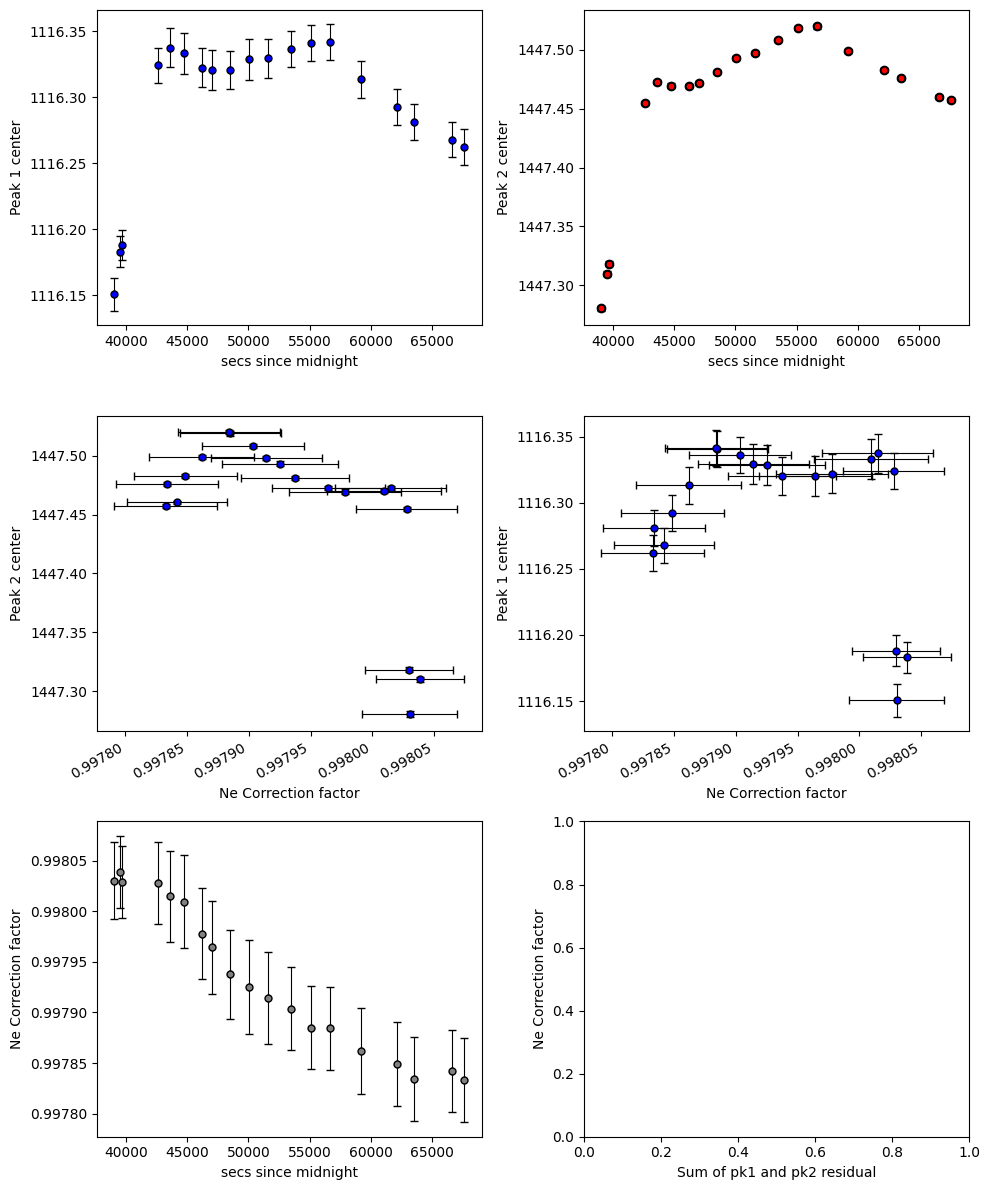

In [22]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [23]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

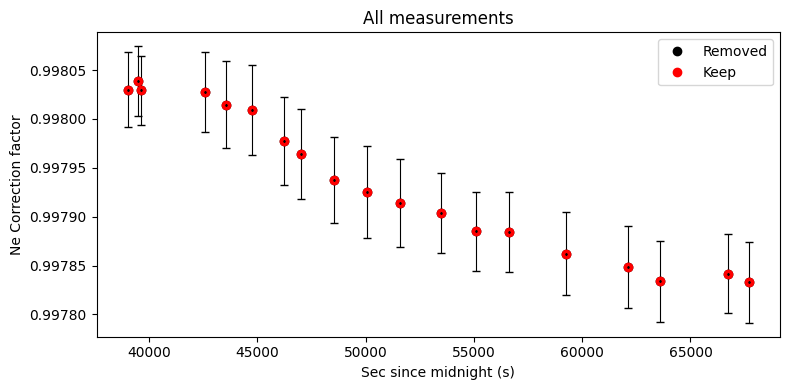

In [24]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

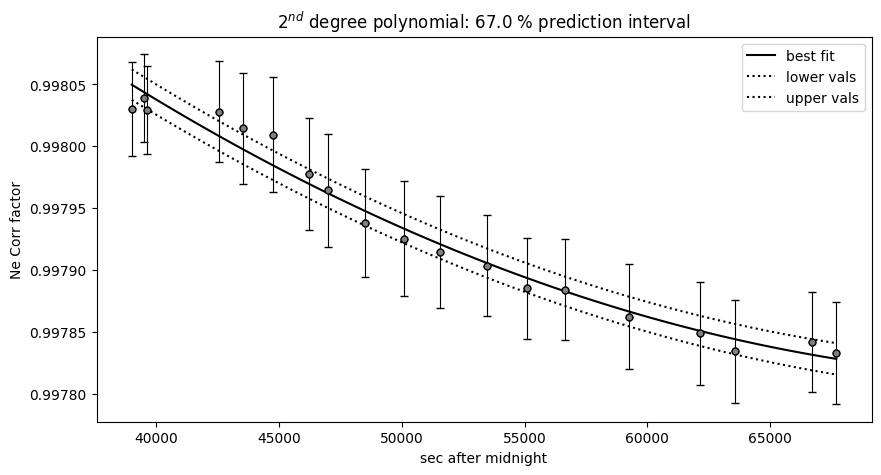

In [25]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model.pkl')
